This notebook consists of following sections:

a. Imported libraries and checking on GPU

b. Customized Functions or/and Classes

c. Main Body

# Importing libraries and checking on GPU

In [1]:
!pip install hdf5storage
!pip install xgboost
!pip install scikit-learn
!pip install tensorflow
!pip install seaborn

# from google.colab import drive
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import keras_tuner
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping
import xgboost as xgb
import tensorflow as tf
import seaborn as sns
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import joblib
import hdf5storage
import datetime
import random

pd.options.display.max_columns = None  # To display all columns in pandas

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(100)

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Checking if GPU available in our system

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# Compare if the GPU is faster than CPU in the system, the perform
# operation with GPU for specific code
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')


def cpu():
    with tf.device('/cpu:0'):
        random_image_cpu = tf.random.normal((100, 100, 100, 3))
        net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
        return tf.math.reduce_sum(net_cpu)


def gpu():
    with tf.device('/device:GPU:0'):
        random_image_gpu = tf.random.normal((100, 100, 100, 3))
        net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
        return tf.math.reduce_sum(net_gpu)


# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time / gpu_time)))

# Customized Functions or/and Classes

In [4]:
# Exception to handle NaN values

class NaNDataException(Exception):
    def __init__(self, message="NaN values encountered"):
        self.message = message
        super().__init__(self.message)

def data_has_nan(data):
    # Check if data contains NaN values and return True or False
    return np.isnan(data).any()

In [23]:
def xgboost_cross_validation(features, label):
    """
    Do the 10-folds cross validation test with XGBoost.

    Input:
      feature_matrix (DataFrame): The raw data of the stock.

    Output:
      all_rmse (list): The list of RMSE for all folds.
    """

    scaler = MinMaxScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(features))

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=10)
    print(tscv)
    print(62 * '#')

    # Set a list to save the rmse for all folds
    all_rmse = []
    counter = 0

    for train_index, test_index in tscv.split(features):

        counter += 1
        print('Fold %d:' % counter)

        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = features.iloc[train_index,
                                        :], features.iloc[test_index, :]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        print(70 * '-')

        # Build the model
        model = XGBRegressor(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            random_state=42)

        # Fit model with history to check for overfitting
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        Y_test_numpy = np.array(y_test)

        rmse = mean_squared_error(Y_test_numpy, y_pred, squared=False)

        print('testScore:', rmse)

        all_rmse.append(rmse)

    return all_rmse


In [2]:
# Grid Search CV with Keras
# Define the model architecture
def create_model(num_units=64, dropout_rate=0.2, look_back=60):
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(look_back, X_train_lstm.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def grid_search(X_train, y_train):
    # Set up the hyperparameter search space
    num_units = [32, 64, 128]
    dropout_rates = [0.1, 0.2, 0.3]
    param_grid = dict(num_units=num_units, dropout_rate=dropout_rates)

    # Create the model and the grid search object
    model = KerasRegressor(
        build_fn=create_model,
        epochs=10,
        batch_size=32,
        verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

    # Fit the grid search object to the data
    grid_result = grid.fit(X_train, y_train)

    # Print the best parameters and the corresponding mean squared error score
    print("Best Parameters: ", grid_result.best_params_)
    print("Best Score: ", np.abs(grid_result.best_score_))

In [3]:
def process_lstm_data(data, look_back=60, horizon=1, jump=1):
    """
    Split the data into X and Y and do data pre-processing for LSTM.

    Input:
        data(NumPy array): The full dataset.
        look_back(int): The number of historical events for LSTM to memorise.
        horizon(int): The number of future LSTM should predict at one time.
        jump(int): The next period we want to predict after each LSTM window.

    Output:
        X(NumPy array): Features in format that is suitable for LSTM.
        Y(NumPy array): Label in format that is suitable for LSTM.
    """

    X, Y = [], []

    for i in range(0, len(data) - look_back - horizon + 1, jump):
        # X contains all columns except the label
        X.append(data[i:(i + look_back), :-1])

        # Y only contains the mid-price (label)
        Y.append(data[(i + look_back - 1):(i + look_back + horizon - 1), -1])

    X = np.array(X)
    Y = np.array(Y)

    return X, Y


In [4]:
def normalise_data(array_raw):
    """
    Normalise the array.
    """
    scaler = MinMaxScaler()
    array = scaler.fit_transform(array_raw)
    return array, scaler


def inverse_predictions(predictions, scaler, prediction_index=-1):
    '''
    This function uses the fitted scaler to inverse predictions,
    the index should be set to the position of the target variable,
    in this case, the last column (mid price column).
    This will be used for the label inverse prediction.
    '''
    max_val = scaler.data_max_[prediction_index]
    min_val = scaler.data_min_[prediction_index]
    original_values = (predictions * (max_val - min_val)) + min_val
    return original_values


In [5]:
def build_lstm(look_back, horizon, X_train, y_train, X_validate, y_validate, i):
    """
    Build and train the the LSTM regression model.

    Input:
      X_train (NumPy array): Training features
      y_train (NumPy array): Training label
      X_validate (NumPy array): Validation features
      y_validate (NumPy array): Validation label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      model (Keras `Sequential`): Trained regression model with LSTM layer
      history (`tf.keras.callbacks.History`): History of model training
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


In [6]:
def lstm(X_train, X_validate, X_test, y_train, y_validate, y_test, i):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
      X_train (NumPy array): Training features
      X_validate (NumPy array): Validation features
      X_test (NumPy array): Test features
      y_train (NumPy array): Training label
      y_validate (NumPy array): Validation label
      y_test (NumPy array): Test label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      rmse (float): The RMSE score from prediction versus y_test
    """
    look_back = 60
    horizon = 1

    # Build the LSTM model
    model, history = build_lstm(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights('/drive/My Drive/Colab Notebooks/FML 2/model_weights.h5')

    # Showing the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    plt.show()

    # Predict
    y_pred_test = model.predict(X_test)

    # Get the original values for mid_price prediction
    y_pred = []
    for i in range(len(y_pred_test)):
        inverse = inverse_predictions(y_pred_test[i], scaler, -1)
        y_pred.append(inverse)
    y_pred = np.array(y_pred)
    # print(y_pred)

    # Get the original values for mid_price in test set
    y_test_inverse = []
    for i in range(len(y_test)):
        inverse = inverse_predictions(y_test[i], scaler, -1)
        y_test_inverse.append(inverse)
    y_test_inverse = np.array(y_test_inverse)

    # Showing prediction vs target
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred.reshape(-1, 1), color='r', label='Prediction')
    plt.plot(y_test_inverse.reshape(-1, 1), label='Target')
    plt.legend(loc='best')
    plt.show()

    # Calculating RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred, squared=False)

    print(f"RMSE LSTM: {rmse}")

    return rmse


In [69]:
def build_lstm_51(look_back, horizon, X_train, y_train, X_validate, y_validate,
                  i):
    """
    Build and train the the LSTM regression model.
    11 features are added to this model, make a total of 51 features.

    Input:
      X_train (NumPy array): Training features
      y_train (NumPy array): Training label
      X_validate (NumPy array): Validation features
      y_validate (NumPy array): Validation label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      model (Keras `Sequential`): Trained regression model with LSTM layer
      history (`tf.keras.callbacks.History`): History of model training
    """
    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/mdl_weights51.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


In [70]:
def lstm_51(X_train, X_validate, X_test, y_train, y_validate, y_test, i):
    """
    Predict the mid price using vanilla LSTM regressor.
    11 features are added to this model, make a total of 51 features.

    Input:
      X_train (NumPy array): Training features
      X_validate (NumPy array): Validation features
      X_test (NumPy array): Test features
      y_train (NumPy array): Training label
      y_validate (NumPy array): Validation label
      y_test (NumPy array): Test label
      i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
      rmse (float): The RMSE score from prediction versus y_test
    """
    look_back = 60
    horizon = 1

    # Build the LSTM model
    model, history = build_lstm_51(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights('/drive/My Drive/Colab Notebooks/FML 2/mdl_weights51.h5')

    # Showing the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    plt.show()

    # Predict
    y_pred_test = model.predict(X_test)

    # Get the original values for mid_price prediction
    y_pred = []
    for i in range(len(y_pred_test)):
        inverse = inverse_predictions(y_pred_test[i], scaler, -1)
        y_pred.append(inverse)
    y_pred = np.array(y_pred)
    # print(y_pred)

    # Get the original values for mid_price in test set
    y_test_inverse = []
    for i in range(len(y_test)):
        inverse = inverse_predictions(y_test[i], scaler, -1)
        y_test_inverse.append(inverse)
    y_test_inverse = np.array(y_test_inverse)

    # Showing prediction vs target
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred.reshape(-1, 1), color='r', label='Prediction')
    plt.plot(y_test_inverse.reshape(-1, 1), label='Target')
    plt.legend(loc='best')
    plt.show()

    # Calculating RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred, squared=False)

    print(f"RMSE LSTM: {rmse}")

    return rmse


In [58]:
def build_lstm_for_ae_plus(
        look_back,
        horizon,
        X_train,
        y_train,
        X_validate,
        y_validate,
        i):
    """
    Build and train the the LSTM regression model.

    Input:
        X_train (NumPy array): Training features
        y_train (NumPy array): Training label
        X_validate (NumPy array): Validation features
        y_validate (NumPy array): Validation label
        i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
        model (Keras `Sequential`): Trained regression model with LSTM layer
        history (`tf.keras.callbacks.History`): History of model training
    """

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae_plus.h5'
        )

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


def lstm_autoencoder_plusfeature(
        X_train,
        X_validate,
        X_test,
        y_train,
        y_validate,
        y_test,
        i,
        latent_dim=20):
    """
    Predict the mid price using LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)
        latent_dim (int): Number of latent dimension extracted from Autoencoder

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """

    look_back = 60
    horizon = 1
    features = X_train_lstm.shape[2]

    encoder_inputs = Input(shape=(look_back, features))
    encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
    decoder = LSTM(features, return_sequences=True)(encoder)
    decoder_outputs = TimeDistributed(Dense(features))(decoder)

    autoencoder = Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(
        monitor='val_loss',
        mode='auto',
        restore_best_weights=True,
        verbose=1,
        patience=10)
    autoencoder.fit(
        X_train,
        X_train,
        epochs=50,
        batch_size=16,
        validation_data=(
            X_validate,
            X_validate),
        callbacks=[es])

    # Use encoder to obtain encoded representation (latent dimension)
    # The combined array consists of 44 features + 20 latent features = 64
    # features
    encoder_model = Model(encoder_inputs, encoder)
    encoded_X_train = encoder_model.predict(X_train)
    combined_X_train_latent = np.concatenate((encoded_X_train, X_train), axis=2)
    encoded_X_test = encoder_model.predict(X_test)
    combined_X_test_latent = np.concatenate((encoded_X_test, X_test), axis=2)
    # print(combined_X_test_latent.shape)

    # Split the training data to 80% training and 20% validation
    X_train, X_validate, y_train, y_validate = train_test_split(
        combined_X_train_latent, y_train, test_size=0.20, random_state=0,
        shuffle=False
    )
    model, history = build_lstm_for_ae_plus(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights(
        '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae_plus.h5')

    # Make predictions on test data
    y_pred = model.predict(combined_X_test_latent)

    y_test_inverse = inverse_predictions(y_test_lstm, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)

    print('RMSE LSTM AE 60 features:', rmse)

    return rmse


In [59]:
def build_lstm_for_ae(
        look_back,
        horizon,
        X_train,
        y_train,
        X_validate,
        y_validate,
        i):
    """
    Predict the mid price using LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)
        latent_dim (int): Number of latent dimension we want to extract from Autoencoder

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fitting the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(
            X_validate,
            y_validate),
        shuffle=False,
        batch_size=16,
        verbose=1,
        callbacks=[early_stopping])

    return model, history


def lstm_autoencoder(
        X_train,
        X_validate,
        X_test,
        y_train,
        y_validate,
        y_test,
        i,
        latent_dim=20):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)
        latent_dim (int): Number of latent dimension we want to extract from Autoencoder

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """
    look_back = 60
    horizon = 1

    encoder_inputs = Input(shape=(look_back, X_train_lstm.shape[2]))
    encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
    decoder = LSTM(X_train_lstm.shape[2], return_sequences=True)(encoder)
    decoder_outputs = TimeDistributed(Dense(X_train_lstm.shape[2]))(decoder)

    autoencoder = Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(
        monitor='val_loss',
        mode='auto',
        restore_best_weights=True,
        verbose=1,
        patience=10)
    autoencoder.fit(
        X_train,
        X_train,
        epochs=50,
        batch_size=16,
        validation_data=(
            X_validate,
            X_validate),
        callbacks=[es])

    # Use encoder to obtain encoded representation of input data (latent
    # dimension)
    encoder_model = Model(encoder_inputs, encoder)
    encoded_X_train = encoder_model.predict(X_train)
    encoded_X_test = encoder_model.predict(X_test)

    # Split the training data to 80% training and 20% validation
    X_train, X_validate, y_train, y_validate = train_test_split(
        encoded_X_train, y_train, test_size=0.20, random_state=0, shuffle=False)
    model, history = build_lstm_for_ae(
        look_back, horizon, X_train, y_train, X_validate, y_validate, i)
    model.save_weights(
        '/drive/My Drive/Colab Notebooks/FML 2/model_weights_lstmae.h5')

    # Make predictions on test data
    y_pred = model.predict(encoded_X_test)

    y_test_inverse = inverse_predictions(y_test_lstm, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)

    print('RMSE LSTM AE with 20 latent features only:', rmse)

    return rmse


In [60]:
def mlp_regression(X_train, y_train, X_validate, y_validate, X_test, y_test, i):
    """
    Predict the mid price using vanilla LSTM regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

    if i != 0:
        model.load_weights(
            '/drive/My Drive/Colab Notebooks/FML 2/model_weights_mlp.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=16,
        verbose=1,
        validation_data=(
            X_validate,
            y_validate),
        callbacks=[early_stop])

    y_pred = model.predict(X_test)

    model.save_weights(
        '/drive/My Drive/Colab Notebooks/FML 2/model_weights_mlp.h5')

    y_test_inverse = inverse_predictions(y_test, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)
    print(f"RMSE for model {i}: {rmse}")

    return rmse


In [61]:
def random_forest_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        n_estimators,
        max_depth,
        min_samples_split,
        min_samples_leaf,
        i):
    """
    Predict the mid price using Random Forests regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        n_estimators (int): The number of trees in the forest
        max_depth(int): The maximum depth of the tree
        i (int): Iteration number in online learning (i=0 means first iteration)
        min_samples_split(int/float): Samples required to split an internal node
        min_samples_leaf(int/flota): Samples required to be at a leaf node

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """
    if i == 0:
        # Create the model
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf)
    else:
        model = joblib.load(
            '/drive/My Drive/Colab Notebooks/FML 2/rf_model.pkl')

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Validate the model on the validation set
    y_pred_val = model.predict(X_validate)
    mse_val = mean_squared_error(y_validate, y_pred_val)
    # print('Validation MSE:', mse_val)

    # Evaluate the model on the test set
    y_pred_test = model.predict(X_test)

    y_test_inverse = inverse_predictions(y_test, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred_test, scaler, -1)

    rmse_test = mean_squared_error(
        y_test_inverse, y_pred_inverse, squared=False)
    print('RMSE Random Forest:', rmse_test)
    joblib.dump(model, '/drive/My Drive/Colab Notebooks/FML 2/rf_model.pkl')
    return rmse_test


In [27]:
def xgboost_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        i):
    """
    Predict the mid price using XGBoost regressor.

    Input:
        X_train (NumPy array): Training features
        X_validate (NumPy array): Validation features
        X_test (NumPy array): Test features
        y_train (NumPy array): Training label
        y_validate (NumPy array): Validation label
        y_test (NumPy array): Test label
        i (int): Iteration number in online learning (i=0 means first iteration)

    Output:
        rmse (float): The RMSE score from prediction versus y_test
    """

    model_path = "/drive/My Drive/Colab Notebooks/FML 2/xgb_model.pkl"
    if i == 0:
        # Define the XGBoost regressor
        xgb_regressor = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            seed=42)
    else:
        # Load the model from the file (for online learning iterations)
        with open(model_path, "rb") as f:
            xgb_regressor = pickle.load(f)

    # Train the model
    xgb_regressor.fit(
        X_train,
        y_train,
        eval_set=[
            (X_validate,
             y_validate)],
        early_stopping_rounds=10,
        verbose=False)

    # Save the model to a file
    with open(model_path, "wb") as f:
        pickle.dump(xgb_regressor, f)

    # Make predictions on the test set
    y_pred = xgb_regressor.predict(X_test)

    y_test_inverse = inverse_predictions(y_test, scaler, -1)
    y_pred_inverse = inverse_predictions(y_pred, scaler, -1)

    # Calculate the RMSE
    rmse = mean_squared_error(y_test_inverse, y_pred_inverse, squared=False)

    print('RMSE XGBoost:', rmse)

    return rmse


# Main Body

In [2]:
# Read the data
LOB_input = hdf5storage.loadmat(
    'S092215-v50-AMZN_OCT2_states.mat')
LOB_Amazon = pd.DataFrame.from_dict(LOB_input['LOB'])

# Add Column Titles
LOB_Amazon.columns = [
    "Time", "Mid_Price", "Spread",
    "AskPrice1", "AskVolume1", "BidPrice1", "BidVolume1",  # Level 1
    "AskPrice2", "AskVolume2", "BidPrice2", "BidVolume2",  # Level 2
    "AskPrice3", "AskVolume3", "BidPrice3", "BidVolume3",  # Level 3
    "AskPrice4", "AskVolume4", "BidPrice4", "BidVolume4",  # Level 4
    "AskPrice5", "AskVolume5", "BidPrice5", "BidVolume5",  # Level 5
    "AskPrice6", "AskVolume6", "BidPrice6", "BidVolume6",  # Level 6
    "AskPrice7", "AskVolume7", "BidPrice7", "BidVolume7",  # Level 7
    "AskPrice8", "AskVolume8", "BidPrice8", "BidVolume8",  # Level 8
    "AskPrice9", "AskVolume9", "BidPrice9", "BidVolume9",  # Level 9
    "AskPrice10", "AskVolume10", "BidPrice10", "BidVolume10",  # Level 10
]

LOB_Amazon["Time"] = pd.to_datetime(LOB_Amazon["Time"], unit='ms')

# Drop rows where the "Mid_Price" column is equal to zero
# From observations, Mid_Price with zero values are either bid or ask
# prices is equal to zero
LOB_Amazon = LOB_Amazon[LOB_Amazon['Mid_Price'] != 0]

# Identify the Columns that will be utilized as inputs to the regressors
# Excluding row 1-2 and last row for the zero value
# Predicting one day after, we started the row from 4
Feature_Matrix = LOB_Amazon.iloc[1:-1, :]
Feature_Matrix = Feature_Matrix.drop(columns=['Mid_Price', 'Spread'])
Mid_Price_Series = LOB_Amazon['Mid_Price'].iloc[2:]

# Create classification labels based on the sign of the differences
diffs = Mid_Price_Series.diff()
classification_labels = pd.Series(
    [0] + [1 if diff > 0 else -1 if diff < 0 else 0 for diff in diffs[1:]])
classification_labels = classification_labels.rename('Class')

# Remove indexes before concatinating
Feature_Matrix.reset_index(drop=True, inplace=True)
Mid_Price_Series.reset_index(drop=True, inplace=True)
classification_labels.reset_index(drop=True, inplace=True)

df = pd.concat([Feature_Matrix, Mid_Price_Series,
               classification_labels], axis=1)
df.set_index('Time', inplace=True)

# Checking if features, labels and df have same rows
print('Mid_Price_Series length:', len(Mid_Price_Series))
print('Feature_Matrix length:', len(Feature_Matrix))
print('Full df length:', len(df))


Mid_Price_Series length: 559716
Feature_Matrix length: 559716
Full df length: 559716


In [3]:
df.head()

AskPrice1  AskVolume1  BidPrice1  BidVolume1  \
Time                                                                    
2015-09-22 04:00:10.073    5476400         100    5427400         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   

                         AskPrice2  AskVolume2  BidPrice2  BidVolume2  \
Time                                                                    
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073    5476800         100    5427400         100   
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073    5484000         100          0           0   

                         AskPrice3  AskVolume3  BidPrice3  BidVolume3  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice4  AskVolume4  BidPrice4  BidVolume4  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice5  AskVolume5  BidPrice5  BidVolume5  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice6  AskVolume6  BidPrice6  BidVolume6  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice7  AskVolume7  BidPrice7  BidVolume7  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   

                         AskPrice8  AskVolume8  BidPrice8  BidVolume8  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
201

In [4]:
# Feature engineering

df_new = df.copy()

time_diffs = df_new.index.to_series().diff()
# Feature 1: FinancialDuration
df_new["FinancialDuration"] = time_diffs.dt.total_seconds().fillna(0)

# Feature 2: MidPrice_OIB
df_new["MidPrice_OIB"] = ((df_new["AskPrice1"]*df_new["AskVolume1"])+(df_new["BidPrice1"]*df_new["BidVolume1"])) / (df_new["AskVolume1"]+df_new["BidVolume1"])
# Feature 3: VolImbalance
df_new["VolImbalance"] = df_new["BidVolume1"] / (df_new["AskVolume1"]+df_new["BidVolume1"])
# Feature 4: BA_spread
df_new["BA_spread"] = df_new["AskPrice1"] - df_new["BidPrice1"]
# Feature 5: AccumulatedVolumeDifference
df_new['AccumulatedVolumeDifference'] = df_new['BidVolume1'] - df_new['AskVolume1']
for i in range(2, 11):
    df_new[f'AccumulatedVolumeDifference'] += df_new[f'BidVolume{i}'] - df_new[f'AskVolume{i}']
# Feature 6: WeightedAverageBidPrice
df_new['WeightedAverageBidPrice'] = sum(df_new[f'BidPrice{i}'] * df_new[f'BidVolume{i}'] for i in range(1, 11)) / sum(df_new[f'BidVolume{i}'] for i in range(1, 11))
# Feature 7: WeightedAverageAskPrice
df_new['WeightedAverageAskPrice'] = sum(df_new[f'AskPrice{i}'] * df_new[f'AskVolume{i}'] for i in range(1, 11)) / sum(df_new[f'AskVolume{i}'] for i in range(1, 11))
# Feature 8: OrderFlowImbalance
df_new['OrderFlowImbalance'] = sum(df_new[f'BidVolume{i}'] - df_new[f'AskVolume{i}'] for i in range(1, 11))
# Feature 9: RelativeBidVolume
df_new['RelativeBidVolume'] = df_new['BidVolume1'] / df_new[['BidVolume{}'.format(i) for i in range(1, 11)]].mean(axis=1)
# Feature 10: RelativeAskVolume
df_new['RelativeAskVolume'] = df_new['AskVolume1'] / df_new[['AskVolume{}'.format(i) for i in range(1, 11)]].mean(axis=1)
lookback_period = 5
df_new['MidPrice'] = (df_new['AskPrice1'] + df_new['BidPrice1']) / 2
# Feature 11: PriceMomentum
df_new['PriceMomentum'] = df_new['MidPrice'].pct_change(periods=lookback_period)
# Drop the feature "MidPrice" after calculating "PriceMomentum"
df_new = df_new.drop('MidPrice', axis=1)

# Feature 12 - Price spreads of level 2
df_new["BA_spread2"] = df_new["AskPrice2"] - df_new["BidPrice2"]

# Feature 13 - Price spreads of level 3
df_new["BA_spread3"] = df_new["AskPrice3"] - df_new["BidPrice3"]

# Feature 14 - Price spreads of level 4
df_new["BA_spread4"] = df_new["AskPrice4"] - df_new["BidPrice4"]

# Feature 15 - Price spreads of level 5
df_new["BA_spread5"] = df_new["AskPrice5"] - df_new["BidPrice5"]

# Feature 16 - Price spreads of level 6
df_new["BA_spread6"] = df_new["AskPrice6"] - df_new["BidPrice6"]

# Feature 17 - Price spreads of level 7
df_new["BA_spread7"] = df_new["AskPrice7"] - df_new["BidPrice7"]

# Feature 18 - Price spreads of level 8
df_new["BA_spread8"] = df_new["AskPrice8"] - df_new["BidPrice8"]

# Feature 19 - Price spreads of level 9
df_new["BA_spread9"] = df_new["AskPrice9"] - df_new["BidPrice9"]

# Feature 20 - Price spreads of level 10
df_new["BA_spread10"] = df_new["AskPrice10"] - df_new["BidPrice10"]

# remove the column and store it in a variable
mid_price = df_new.pop('Mid_Price')  

df_new['Mid_Price'] = mid_price

class_pop = df_new.pop('Class')  # remove the column and store it in a variable
df_new['Class'] = class_pop  # add the column back to the DataFrame as the last column

df_new.shape #(53 columns, the last two features are regression and classification labels)

(559716, 62)

In [5]:
# Feature selection with variance threshold

df_features = df_new.iloc[:, 0:60]

# Create thresholder, omit feature with 0.1 variance
thresholder = VarianceThreshold(threshold=0.1)

# Create high variance feature matrix
features_high_variance = thresholder.fit_transform(df_features)
filtered = thresholder.get_support()
df_features_new = df_features.iloc[:, filtered]
df_features_new = df_features_new.fillna(0)

# Dataframe df_final is after filtering features with 0.1 variance (if any)
df_final = pd.concat(
    [df_features_new, df_new.iloc[:, -2], df_new.iloc[:, -1]], axis=1)
df_final.shape

(559716, 60)

In [6]:
df_features

AskPrice1  AskVolume1  BidPrice1  BidVolume1  \
Time                                                                    
2015-09-22 04:00:10.073    5476400         100    5427400         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   

                         AskPrice2  AskVolume2  BidPrice2  BidVolume2  \
Time                                                                    
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073    5476800         100    5427400         100   
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073    5484000         100          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   

                         AskPrice3  AskVolume3  BidPrice3  BidVolume3  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   

                         AskPrice4  AskVolume4  BidPrice4  BidVolume4  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    3777700          30   
2015-09-22 20:00:00.092          0           0          0           0   

                         AskPrice5  AskVolume5  BidPrice5  BidVolume5  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-0

In [7]:
df_features_new

AskPrice1  AskVolume1  BidPrice1  BidVolume1  \
Time                                                                    
2015-09-22 04:00:10.073    5476400         100    5427400         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   

                         AskPrice2  AskVolume2  BidPrice2  BidVolume2  \
Time                                                                    
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073    5476800         100    5427400         100   
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073    5484000         100          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   

                         AskPrice3  AskVolume3  BidPrice3  BidVolume3  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   

                         AskPrice4  AskVolume4  BidPrice4  BidVolume4  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    3777700          30   
2015-09-22 20:00:00.092          0           0          0           0   

                         AskPrice5  AskVolume5  BidPrice5  BidVolume5  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-0

In [6]:
# create a boolean mask to filter rows where BidPrice1 > AskPrice1
# In Microstructure, bid price can not exceed ask price
mask = df_final["BidPrice1"] > df_final["AskPrice1"]

# filter the rows where BidPrice1 > AskPrice1
filtered_df = df_final[mask]

# check if the filtered DataFrame has any rows
if not filtered_df.empty:
    print("There are some rows where BidPrice1 > AskPrice1")
else:
    print("All rows satisfy BidPrice1 <= AskPrice1")


All rows satisfy BidPrice1 <= AskPrice1


In [13]:
# A heatmap visualization of the correlation matrix using Spearman
# Spearman correlation matrix shows the monotonic relationship between variables. However, it does

corr_matrix = df_final.corr(method='spearman')
fig, ax = plt.subplots(figsize=(40, 35))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

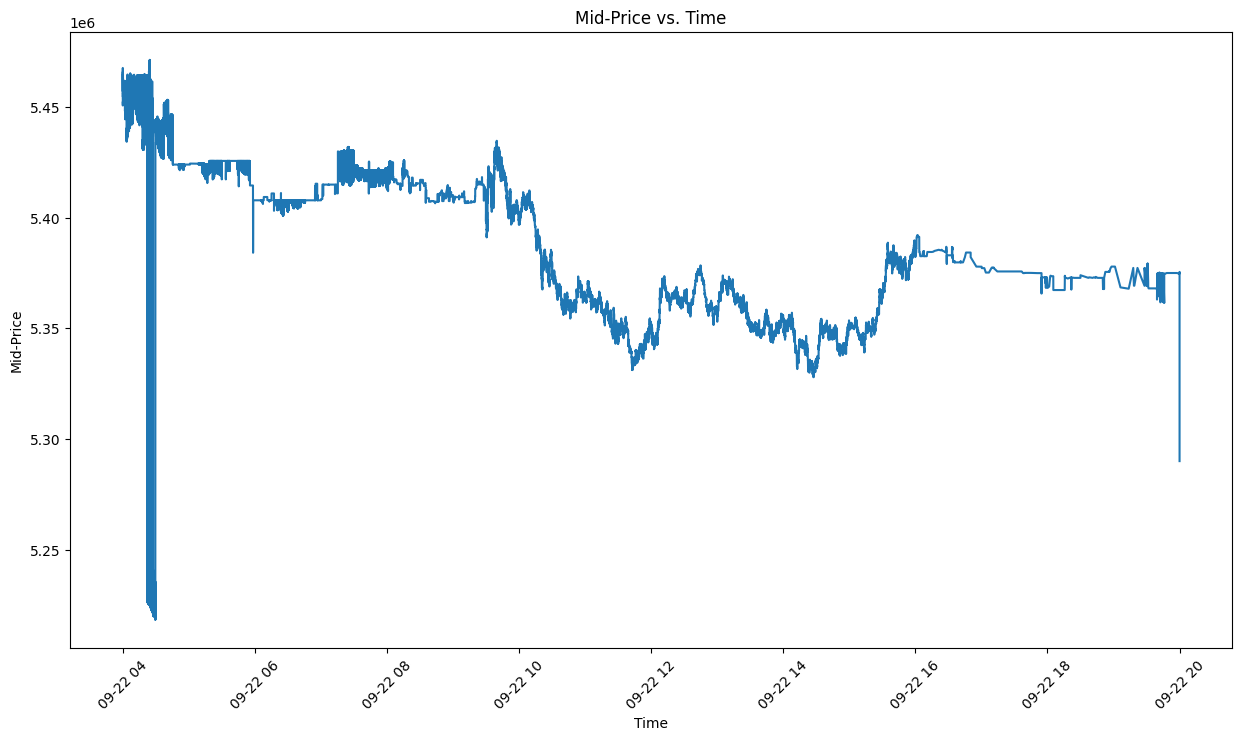

In [14]:
# plot the "Mid_Price" column
plt.figure(figsize=(15, 8))

plt.plot(df_final["Mid_Price"])

# rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# add axis labels and a title
plt.xlabel("Time")
plt.ylabel("Mid-Price")
plt.title("Mid-Price vs. Time")

# display the plot
plt.show()


In [7]:
df_features_new

AskPrice1  AskVolume1  BidPrice1  BidVolume1  \
Time                                                                    
2015-09-22 04:00:10.073    5476400         100    5427400         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   

                         AskPrice2  AskVolume2  BidPrice2  BidVolume2  \
Time                                                                    
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073    5476800         100    5427400         100   
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073    5484000         100          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   

                         AskPrice3  AskVolume3  BidPrice3  BidVolume3  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   

                         AskPrice4  AskVolume4  BidPrice4  BidVolume4  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    3777700          30   
2015-09-22 20:00:00.092          0           0          0           0   

                         AskPrice5  AskVolume5  BidPrice5  BidVolume5  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-0

In [365]:
np.isnan(df_normalized).any()

False

In [9]:
# Applying PCA
from sklearn.preprocessing import StandardScaler

def variances_pca(df):
    # Normalize the features
    scaler = StandardScaler()
    df_normalized = scaler.fit_transform(df)
    
    # Fit the PCA to all the features
    pca = PCA()
    pca.fit_transform(df_normalized)

    # print the variances of the first ten components
    print("Variance explained by the first ten components:")
    print(np.round(pca.explained_variance_[:10], 10))


variances_pca(df_features_new)


Variance explained by the first ten components:
[10.6302  3.6933  2.9638  2.7091  2.0473  2.0339  2.0196  2.0103  1.9997
  1.9648]


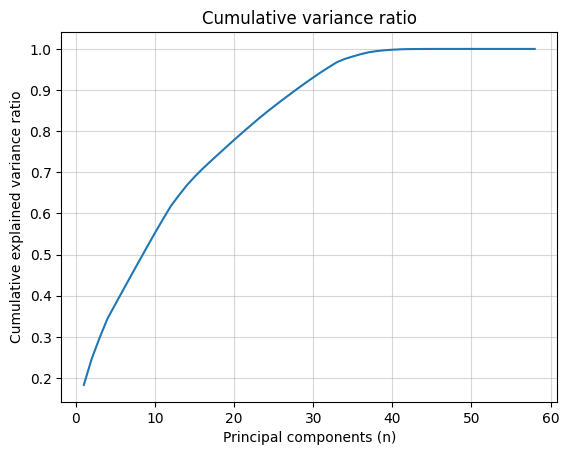

In [10]:
# (2) Your code goes here
def plot_graph(df):
    
    # Normalize the features
    scaler = StandardScaler()
    df_normalized = scaler.fit_transform(df)
    
    # Fit PCA to all features
    pca = PCA()
    pca.fit_transform(df_normalized)

    # Calculate and plot the cumulative variance ratio
    cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio)

    plt.xlabel("Principal components (n)")
    plt.ylabel("Cumulative explained variance ratio")
    plt.title("Cumulative variance ratio")
    plt.grid(alpha=0.5)
    plt.show()


plot_graph(df_features_new)


In [11]:
def find_components(df, total_var=[50, 60, 70, 80, 90, 95, 97, 99, 100]):
    
    # Normalize the features
    scaler = MinMaxScaler()
    df_normalized = scaler.fit_transform(df)
    
    pca = PCA()
    pca.fit_transform(df_normalized)
    min_components = []

    # Calculate the cumulative explained variance ratio
    cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    for var in total_var:
        min_components.append(np.argmax(cumulative_var_ratio >= var * 0.01) + 1)

    # Calculate the number of principal components
    for i, var in enumerate(total_var):
        print(
            f"Number of principal components that explain {var}% of the variance is {min_components[i]}")

find_components(df_features_new, [50, 60, 70, 80, 90, 95, 97, 99])

Number of principal components that explain 50% of the variance is 1
Number of principal components that explain 60% of the variance is 1
Number of principal components that explain 70% of the variance is 1
Number of principal components that explain 80% of the variance is 3
Number of principal components that explain 90% of the variance is 7
Number of principal components that explain 95% of the variance is 13
Number of principal components that explain 97% of the variance is 17
Number of principal components that explain 99% of the variance is 25


In [12]:
# We will extract the principal components equal to six as it explains 99%
# of variance

pca = PCA(n_components=25)

# Normalize the features
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_features_new)

# Fit and transform the DataFrame
principal_components = pca.fit_transform(df_normalized)

# Create a new DataFrame with the principal components
df_principal_components = pd.DataFrame(
    data=principal_components, columns=[
        'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12',
    'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22',
    'PC23', 'PC24', 'PC25'])

print(df_principal_components.shape)


(559716, 25)


In [24]:
# Using 60 features for XGBoost Regressor
xgboost_rmse_60 = xgboost_cross_validation(
    df_features_new, df_final.iloc[:, -2])


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------
testScore: 12707.377058163202
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------
testScore: 6603.264955726539
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------
testScore: 8321.191129294295
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------
testScore: 5410.054595898961
Fold 5:
TRAIN: 254418 TEST: 50883
----------------------------------------------------------------------
testScore: 804.5007306635767
Fold 6:
TRAIN: 305301 TEST: 50883
----------------------------------------------------------------------
testScore: 732.8386993723796
Fold 7:
TRAIN: 356184 TEST: 50883
--------------------------

In [25]:
# Using only 40 features (without feature engineering)
xgboost_rmse_40 = xgboost_cross_validation(
    df_features_new.iloc[:, :40], df_final.iloc[:, -2])


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------
testScore: 10658.346762982528
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------
testScore: 6996.091035111965
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------
testScore: 10788.392867137818
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------
testScore: 15069.404753612402
Fold 5:
TRAIN: 254418 TEST: 50883
----------------------------------------------------------------------
testScore: 826.3419788497231
Fold 6:
TRAIN: 305301 TEST: 50883
----------------------------------------------------------------------
testScore: 816.947761150632
Fold 7:
TRAIN: 356184 TEST: 50883
-------------------------

In [26]:
# XGBoost Regressor with 25 principal components
xgboost_rmse_25 = xgboost_cross_validation(
    df_principal_components, df_final.iloc[:, -2])


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------
testScore: 22101.031388176485
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------
testScore: 14778.622177685778
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------
testScore: 16687.039607604333
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------
testScore: 14188.203238971959
Fold 5:
TRAIN: 254418 TEST: 50883
----------------------------------------------------------------------
testScore: 3327.3064599999125
Fold 6:
TRAIN: 305301 TEST: 50883
----------------------------------------------------------------------
testScore: 4172.049417090423
Fold 7:
TRAIN: 356184 TEST: 50883
----------------------

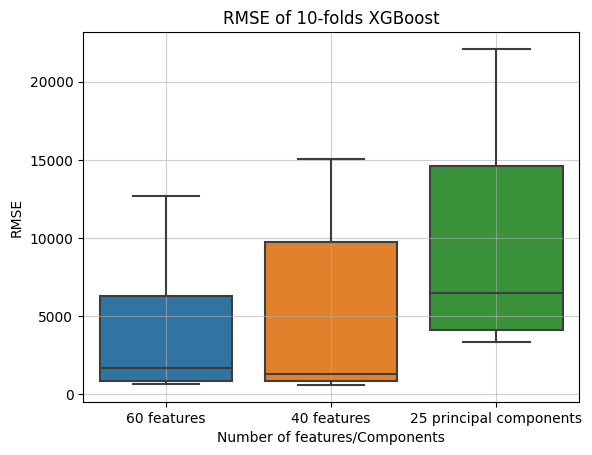

Mean of 60 features:3965.9384315004536
Mean of 40 features:4913.90827258554
Mean of 25 principal components:9593.24595127977


Median of 60 features:1694.4507188188763
Median of 40 features:1283.317290735159
Median of 25 principal components:6485.63224807758


In [27]:
# Plot the box plot for RMSE
all_rmse = [xgboost_rmse_60, xgboost_rmse_40, xgboost_rmse_25]
names = ["60 features", "40 features", "25 principal components"]
sns.boxplot(data=all_rmse)
plt.xticks(range(len(all_rmse)), names)
plt.xlabel('Number of features/Components')
plt.title('RMSE of 10-folds XGBoost')
plt.ylabel('RMSE')
plt.grid(alpha=0.6)
plt.show()

print(f"Mean of 60 features:{np.mean(xgboost_rmse_60)}")
print(f"Mean of 40 features:{np.mean(xgboost_rmse_40)}")
print(f"Mean of 25 principal components:{np.mean(xgboost_rmse_25)}")
print("\n")
print(f"Median of 60 features:{np.median(xgboost_rmse_60)}")
print(f"Median of 40 features:{np.median(xgboost_rmse_40)}")
print(f"Median of 25 principal components:{np.median(xgboost_rmse_25)}")


In [31]:
first_column = df_features_new.iloc[:5597, 0]
first_column.describe()

count    5.597000e+03
mean     5.473629e+06
std      1.301949e+04
min      5.453400e+06
25%      5.462500e+06
50%      5.474100e+06
75%      5.485600e+06
max      5.507700e+06
Name: AskPrice1, dtype: float64

In [32]:
selected_features = df_features_new.loc[:, (df_features_new != 0).mean() > 0.8]
selected_features.shape

(559716, 57)

In [30]:
x = df_features_new[df_features_new == 0]

In [160]:
percentage_zeros = (df_features_new == 0).mean() * 100
percentage_zeros

AskPrice1                       0.000000
AskVolume1                      0.000000
BidPrice1                       0.000000
BidVolume1                      0.000000
AskPrice2                       2.254358
AskVolume2                      2.254358
BidPrice2                       2.213444
BidVolume2                      2.213444
AskPrice3                       6.577800
AskVolume3                      6.577800
BidPrice3                       4.613411
BidVolume3                      4.613411
AskPrice4                      10.655046
AskVolume4                     10.655046
BidPrice4                       6.774686
BidVolume4                      6.774686
AskPrice5                      13.420913
AskVolume5                     13.420913
BidPrice5                       8.969728
BidVolume5                      8.969728
AskPrice6                      14.472697
AskVolume6                     14.472697
BidPrice6                      11.072937
BidVolume6                     11.072937
AskPrice7       

In [295]:
def kmeans(X, k):
    # k = 2
    # X = 100 data points
    # Initialize Clusters - Randomly (we can also start from actual data points of the input data)
    # to initialize the centroid from randomly instead of from a point:
    
    # Chosing two random numbers from all data points as centroid
    clusters = np.random.choice(np.squeeze(X), size=k) #they are just two random numbers
    
    # See appendix 2 on note
    old_clusters = clusters.copy() #We calculate copy the clusters so that we can compare the distance

    stds = np.zeros(k) #Allocate memory 
    converged = False

    # ----------------------- Looping until Convergence ----------------------- #
    while not converged:
        # Broadcasting for convenience
        # https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html
        point_cluster_dist = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :])) 

        # Classify points to clusters based on the shortest distance
        # https://numpy.org/doc/stable/reference/generated/numpy.argmin.html
        shortest_path_cl = np.argmin(point_cluster_dist, axis=1)

        # Refresh cluster mean based on indexing 
        for i in range(k):#loop two times because k = 2
            indexing = X[shortest_path_cl == i]
            if len(indexing) > 0: #secure that the cluster it is NOT empty
                clusters[i] = np.mean(indexing, axis=0)

        # Converge check - clusters stability
        # when the distance between clusters and old clusters is not moving anymore, stop the iteration
        # https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
        converged = np.linalg.norm(clusters - old_clusters) < 1e-6 #Logical expression check
        old_clusters = clusters.copy()
    # ------------------------------------------------------------------------- #    

    # Final Version of the Converged Data
    # np.newaxis() will convert from (100,) to (100,1) so that we can multiply e.g. [100,1]*[1,2]
    point_cluster_dist = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    
    #to check argmin for every columns
    shortest_path_cl = np.argmin(point_cluster_dist, axis=1)

    # Calculate Standard Deviation per Cluster
    for i in range(k):
        # if it's 0, collect to 
        indexing = X[shortest_path_cl == i]
        #print(indexing)
        stds[i] = np.std(X[shortest_path_cl == i])
    
#     print("Means:")
#     print(clusters)
#     print("Standard deviation:")
#     print(stds)
    return clusters, stds

df_features_selected = pd.DataFrame()
df_features_omitted = pd.DataFrame()
for j in range(0, 60):
    X = df_features_new.iloc[:, j]
    column_name = X.name
    X_array = X.values
    centres, stds = kmeans(X_array, 2)
    if np.any(centres == 0.0) or np.any(stds == 0.0):
        df_features_omitted[column_name] = X_array
    else:
        df_features_selected[column_name] = X_array

In [296]:
df_features_selected

AskPrice1  AskVolume1  BidPrice1  BidVolume1  AskVolume2  BidVolume2   
0         5476400         100    5427400         100         100           0  \
1         5476400         100    5427600         100         100         100   
2         5476400         100    5427600         100         100           0   
3         5476400         100    5427600         100           0           0   
4         5476400         100    5427600         100         100           0   
...           ...         ...        ...         ...         ...         ...   
559711    5390000         100    5300000          10           0          50   
559712    5390000         100    5300000          10           0          50   
559713    5390000         100    5300000          10           0          50   
559714    5390000         100    5300000          10           0          50   
559715    5390000         100    5300000          10           0          50   

        AskVolume3  BidVolume3  AskVolume4  BidVolume4  AskVolume5   
0                0           0           0           0           0  \
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
559711           0          10           0          20           0   
559712           0          10           0          20           0   
559713           0          10           0          20           0   
559714           0          20           0          30           0   
559715           0          20           0           0           0   

        BidVolume5  AskVolume6  BidVolume6  AskVolume7  BidVolume7   
0                0           0           0           0           0  \
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
559711          30           0          20           0          30   
559712          20           0          30           0           0   
559713          30           0           0           0           0   
559714           0           0           0           0           0   
559715           0           0           0           0           0   

        AskVolume8  BidVolume8  AskVolume9  BidPrice9  BidVolume9   
0                0           0           0          0           0  \
1                0           0           0          0           0   
2                0           0           0          0           0   
3                0           0           0          0           0   
4                0           0           0          0           0   
...            ...         ...         ...        ...         ...   
559711           0           0           0          0           0   
559712           0           0           0          0           0   
559713           0           0           0          0           0   
559714           0           0           0          0           0   
559715           0           0           0          0           0   

        AskVolume10  BidPrice10  BidVolume10  FinancialDuration  MidPrice_OIB   
0                 0           0            0              0.000  5.451900e+06  \
1                 0           0            0              0.000  5.452000e+06   
2                 0           0            0              0.000  5.452000e+06   
3                 0           0            0              0.000  5.452000e+06   
4                 0           0            0              0.000  5.452000e+06   
...             ...         ...          ...      

In [297]:
df_features_omitted

AskPrice2  BidPrice2  AskPrice3  BidPrice3  AskPrice4  BidPrice4   
0         5476800          0          0          0          0          0  \
1         5476800    5427400          0          0          0          0   
2         5476800          0          0          0          0          0   
3               0          0          0          0          0          0   
4         5484000          0          0          0          0          0   
...           ...        ...        ...        ...        ...        ...   
559711          0    5190000          0    4900000          0    4750000   
559712          0    5190000          0    4900000          0    4750000   
559713          0    5190000          0    4900000          0    4200000   
559714          0    5190000          0    4200000          0    3777700   
559715          0    5190000          0    4200000          0          0   

        AskPrice5  BidPrice5  AskPrice6  BidPrice6  AskPrice7  BidPrice7   
0               0          0          0          0          0          0  \
1               0          0          0          0          0          0   
2               0          0          0          0          0          0   
3               0          0          0          0          0          0   
4               0          0          0          0          0          0   
...           ...        ...        ...        ...        ...        ...   
559711          0    4653300          0    4200000          0    3777700   
559712          0    4200000          0    3777700          0          0   
559713          0    3777700          0          0          0          0   
559714          0          0          0          0          0          0   
559715          0          0          0          0          0          0   

        AskPrice8  BidPrice8  AskPrice9  AskPrice10  PriceMomentum   
0               0          0          0           0       0.000000  \
1               0          0          0           0       0.000000   
2               0          0          0           0       0.000000   
3               0          0          0           0       0.000000   
4               0          0          0           0       0.000000   
...           ...        ...        ...         ...            ...   
559711          0          0          0           0      -0.005369   
559712          0          0          0           0      -0.004813   
559713          0          0          0           0       0.000000   
559714          0          0          0           0       0.000000   
559715          0          0          0           0       0.000000   

        BA_spread10  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
559711            0  
559712            0  
559713            0  
559714            0  
559715            0  

[559716 rows x 18 columns]

In [303]:
# RBFNN

# Radial Basis Function
def rbf(X, cntrs, std):
    rbf_out = np.exp(-1 / (2 * std**2) * (X-cntrs)**2)
    return rbf_out

class RBFNN(object):
      
    # Constructor for class attributes initialization
    def __init__(self, k=2, lr=0.01, epochs=20, rbf=rbf):
        # lr is learning rate
        # epoch is how many iterations backwards
        # rbf is rbf function above
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
    
    # analogy: fitting clothes before buying 
    def _fit(self, X, y):
       
        # Data's standard deviation
        self.clusters, self.stds = kmeans(X, self.k)

        # Online training = The data is available in sequence order
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # Forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.clusters, self.stds)])
                # zip() is for zipping classes to avoid nested loops to reduce time complexity
                F = a.T.dot(self.w)
                # we have to transpose the matrix for dot product
                
                # Appendix 4
                # https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html
                loss = (y[i] - F).flatten() ** 2
                #print('Loss: {0:.2f}'.format(loss[0]))

                # Backward pass
                # Derivatives
                error = -(y[i] - F).flatten()

                # Online update
                # Going backward
                self.w = self.w - self.lr * a * error

    def _predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.clusters, self.stds)])
            F = a.T.dot(self.w)
            y_pred.append(F)
        return np.array(y_pred)
    

y_pred = []
# count = 0
for name in df_features_selected:
    X = df_features_selected[name]
    X_array = X.values
    y = df_final.iloc[:, -2]
    y_array = y.values
    
    rbfNN = RBFNN(lr=1e-2, k=2)
    rbfNN._fit(X_array, y_array)
    y_prediction = rbfNN._predict(X_array)
    y_pred.append(y_prediction)

In [300]:
mean_y_pred = np.mean(y_pred, axis=0)
df_features_selected.shape

(559716, 42)

In [182]:
X = df_features_new.iloc[:, 1]
X_array = X.values

# Get unique values and their counts
unique_values, value_counts = np.unique(X_array, return_counts=True)

# Calculate percentages
percentages = value_counts / len(X_array) * 100

# Print results
for value, count, percentage in zip(unique_values, value_counts, percentages):
    print(f"Value: {value}, Count: {count}, Percentage: {percentage:.2f}%")

Value: 1, Count: 6842, Percentage: 1.22%
Value: 2, Count: 681, Percentage: 0.12%
Value: 3, Count: 614, Percentage: 0.11%
Value: 4, Count: 248, Percentage: 0.04%
Value: 5, Count: 2406, Percentage: 0.43%
Value: 6, Count: 968, Percentage: 0.17%
Value: 7, Count: 152, Percentage: 0.03%
Value: 8, Count: 814, Percentage: 0.15%
Value: 9, Count: 444, Percentage: 0.08%
Value: 10, Count: 4857, Percentage: 0.87%
Value: 11, Count: 11733, Percentage: 2.10%
Value: 12, Count: 946, Percentage: 0.17%
Value: 13, Count: 213, Percentage: 0.04%
Value: 14, Count: 151, Percentage: 0.03%
Value: 15, Count: 740, Percentage: 0.13%
Value: 16, Count: 202, Percentage: 0.04%
Value: 17, Count: 24, Percentage: 0.00%
Value: 18, Count: 450, Percentage: 0.08%
Value: 19, Count: 471, Percentage: 0.08%
Value: 20, Count: 1528, Percentage: 0.27%
Value: 21, Count: 250, Percentage: 0.04%
Value: 22, Count: 150, Percentage: 0.03%
Value: 23, Count: 6246, Percentage: 1.12%
Value: 24, Count: 160, Percentage: 0.03%
Value: 25, Count: 3

In [256]:
max_value = np.max(mean_y_pred)
min_value = np.min(mean_y_pred)
mean_value = np.mean(mean_y_pred)

print("Maximum value:", max_value)
print("Minimum value:", min_value)
print("Mean value:", mean_value)

Maximum value: 6162888.428042653
Minimum value: 3909671.866137068
Mean value: 5548649.860592221


In [ ]:
rmse = mean_squared_error(mean_y_pred, y_array, squared=False)

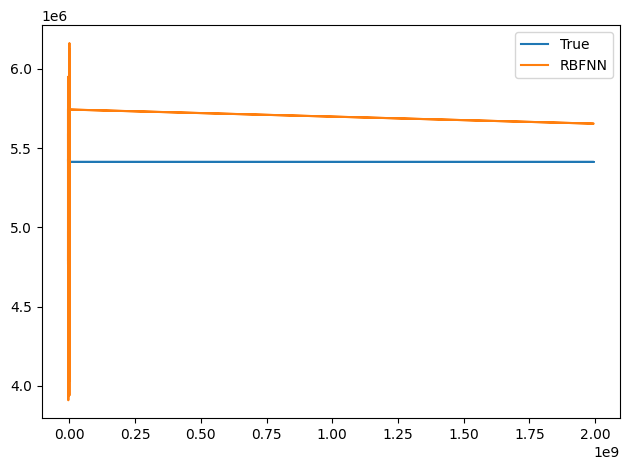

In [260]:
plt.plot(X_array, y_array, label='True')
plt.plot(X_array, mean_y_pred, label='RBFNN')
plt.legend()

plt.tight_layout()
plt.show()

In [283]:
# Define on how many we want to split the data
# We simulate that 100 splits = 100 events to save resource in this assignment
num_splits = 100

# Calculate the size of each split
split_size = len(df_final) // num_splits

# Split the DataFrame into a list of smaller DataFrames
data_splits = [
    df_final.iloc[i * split_size:(i + 1) * split_size] for i in range(num_splits)]

# If there are any remaining data points, add them to the last split
if len(data_splits) % num_splits != 0:
    data_splits[-1] = data_splits[-1].append(
        df_final.iloc[num_splits * split_size:])

# How many data we want to use in this online learning simulation
# E.g. : data_chunk = 10 means 10 out of 100 chunks (10% data)
data_chunk = 2

rbfnn_rmse = []

for i, df_content in enumerate(data_splits):
    if i == data_chunk:
        break
        
    # Select all column, except the class label (last column)
    df_chunk = df_content.iloc[:, 0:61]
    df_chunk_features = df_content.iloc[:, 0:60]
    array_chunk = df_chunk.values

    # Only use original 60 features for this online learning
    label = array_chunk[:, -1]
    X, X_test, y, y_test = train_test_split(
        features, label, test_size=0.20, random_state=0, shuffle=False)
    X_train, X_validate, y_train, y_validate = train_test_split(
        X, y, test_size=0.20, random_state=0, shuffle=False)
    
    count = 0
    df_features_selected = pd.DataFrame()
    df_features_omitted = pd.DataFrame()
    for j in range(0, 60):
        X = df_chunk_features.iloc[:, j]
        column_name = X.name
        X_array = X.values
        centres, stds = kmeans(X_array, 2)
        if np.any(centres == 0.0) or np.any(stds == 0.0):
            df_features_omitted[column_name] = X_array
        else:
            df_features_selected[column_name] = X_array
        
        y_pred = []
        for name in df_features_selected:
            X = df_features_selected[name]
            X_array = X.values
            y = df_final.iloc[:, -2]
            y_array = y.values

            rbfNN = RBFNN(lr=1e-2, k=2
                          
            rbfNN._fit(X_array, y_array)
            y_prediction = rbfNN._predict(X_array)
            y_pred.append(y_prediction)
            
    mean_y_pred = np.mean(y_pred, axis=0)
    rmse = mean_squared_error(mean_y_pred, label, squared=False)
    print(rmse)
    
    rbfnn_rmse.append(rmse)

839146.7828865651


ValueError: Input contains NaN.

In [285]:
# Define on how many we want to split the data
# We simulate that 100 splits = 100 events to save resource in this assignment
num_splits = 10

# Calculate the size of each split
split_size = len(df_final) // num_splits

# Split the DataFrame into a list of smaller DataFrames
data_splits = [
    df_final.iloc[i * split_size:(i + 1) * split_size] for i in range(num_splits)]

# If there are any remaining data points, add them to the last split
if len(data_splits) % num_splits != 0:
    data_splits[-1] = data_splits[-1].append(
        df_final.iloc[num_splits * split_size:])

# How many data we want to use in this online learning simulation
# E.g. : data_chunk = 10 means 10 out of 100 chunks (10% data)
data_chunk = 1

rbfnn_rmse = []

for i, df_content in enumerate(data_splits):
    if i == data_chunk:
        break
        
    # Select all column, except the class label (last column)
    df_chunk = df_content.iloc[:, 0:61]
    df_chunk_features = df_content.iloc[:, 0:60]
    array_chunk = df_chunk.values

    # Only use original 60 features for this online learning
#     label = array_chunk[:, -1]
#     X, X_test, y, y_test = train_test_split(
#         df_chunk_features, label, test_size=0.20, random_state=0, shuffle=False)
#     X_train, X_validate, y_train, y_validate = train_test_split(
#         X, y, test_size=0.20, random_state=0, shuffle=False)
    
    count = 0
    df_features_selected = pd.DataFrame()
    df_features_omitted = pd.DataFrame()
    for j in range(0, 60):
        X = df_chunk_features.iloc[:, j]
        column_name = X.name
        X_array = X.values
        centres, stds = kmeans(X_array, 2)
        if np.any(centres == 0.0) or np.any(stds == 0.0):
            df_features_omitted[column_name] = X_array
        else:
            df_features_selected[column_name] = X_array
        
        y_pred = []
        for name in df_features_selected:
            X = df_features_selected[name]
            X_array = X.values
            y = df_final.iloc[:, -2]
            y_array = y.values

            rbfNN = RBFNN(lr=1e-2, k=2)
            rbfNN._fit(X_array, y_array)
            y_prediction = rbfNN._predict(X_array)
            y_pred.append(y_prediction)
            
    mean_y_pred = np.mean(y_pred, axis=0)
    rmse = mean_squared_error(mean_y_pred, label, squared=False)
    print(rmse)
    
    rbfnn_rmse.append(rmse)

969395.8535377552


In [279]:
df_features_selected

AskPrice1  AskVolume1  BidPrice1  FinancialDuration  MidPrice_OIB   
0       5467300         100    5420200              0.101     5443750.0  \
1       5467300         100    5420200              0.000     5443750.0   
2       5467200         100    5420200              0.063     5443700.0   
3       5467200         100    5420200              0.000     5443700.0   
4       5467100         100    5420100              0.071     5443600.0   
...         ...         ...        ...                ...           ...   
5592    5445200         150    5420800              0.042     5435440.0   
5593    5445200         150    5420800              0.000     5435440.0   
5594    5445200         150    5420800              0.035     5435440.0   
5595    5445200         150    5420000              0.961     5435120.0   
5596    5445200         150    5421400              0.005     5435680.0   

      BA_spread  AccumulatedVolumeDifference  WeightedAverageBidPrice   
0         47100                         -200                5420150.0  \
1         47100                         -300                5420200.0   
2         47000                         -400                5420200.0   
3         47000                         -300                5420200.0   
4         47000                         -300                5420100.0   
...         ...                          ...                      ...   
5592      24400                          -50                5418850.0   
5593      24400                         -150                5420800.0   
5594      24400                          -50                5420400.0   
5595      25200                         -150                5420000.0   
5596      23800                         -150                5421400.0   

      WeightedAverageAskPrice  OrderFlowImbalance  RelativeAskVolume   
0                   5495075.0                -200                2.5  \
1                   5495075.0                -300                2.5   
2                   5489500.0                -400                2.0   
3                   5495050.0                -300                2.5   
4                   5495025.0                -300                2.5   
...                       ...                 ...                ...   
5592                5467760.0                 -50                6.0   
5593                5467760.0                -150                6.0   
5594                5467760.0                 -50                6.0   
5595                5467760.0                -150                6.0   
5596                5467760.0                -150                6.0   

      PriceMomentum  BA_spread2  BA_spread3  BA_spread4  BA_spread5  
0          0.000009       84100     5504400           0           0  
1         -0.000009     5504200     5504400           0           0  
2         -0.000018     5467300     5504200     5504400           0  
3         -0.000009     5504200     5504400           0           0  
4         -0.000018     5504200     5504400           0           0  
...             ...         ...         ...         ...         ...  
5592      -0.000579       84700           0           0           0  
5593      -0.000359     5501600           0           0           0  
5594      -0.000359       81600           0           0           0  
5595      -0.000166     5501600           0           0           0  
5596       0.000414     5501600           0           0           0  

[5597 rows x 16 columns]

In [9]:
df_features_new

AskPrice1  AskVolume1  BidPrice1  BidVolume1  \
Time                                                                    
2015-09-22 04:00:10.073    5476400         100    5427400         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
2015-09-22 04:00:10.073    5476400         100    5427600         100   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   
2015-09-22 20:00:00.092    5390000         100    5300000          10   

                         AskPrice2  AskVolume2  BidPrice2  BidVolume2  \
Time                                                                    
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073    5476800         100    5427400         100   
2015-09-22 04:00:10.073    5476800         100          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073    5484000         100          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   
2015-09-22 20:00:00.092          0           0    5190000          50   

                         AskPrice3  AskVolume3  BidPrice3  BidVolume3  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4900000          10   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   

                         AskPrice4  AskVolume4  BidPrice4  BidVolume4  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
2015-09-22 04:00:10.073          0           0          0           0   
...                            ...         ...        ...         ...   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4750000          20   
2015-09-22 20:00:00.092          0           0    4200000          20   
2015-09-22 20:00:00.092          0           0    3777700          30   
2015-09-22 20:00:00.092          0           0          0           0   

                         AskPrice5  AskVolume5  BidPrice5  BidVolume5  \
Time                                                                    
2015-09-22 04:00:10.073          0           0          0           0   
2015-0

In [14]:
from sklearn.svm import SVC

def svm_rbf(features, label):
    """
    Do the 10-folds cross validation test with SVM RBF kernel.

    Input:
      feature_matrix (DataFrame): The raw data of the stock.

    Output:
      all_rmse (list): The list of RMSE for all folds.
    """

    scaler = MinMaxScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(features))

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=10)
    print(tscv)
    print(62 * '#')

    # Set a list to save the accuracy for all folds
    counter = 0
    svm_rbf = []

    for train_index, test_index in tscv.split(features):

        counter += 1
        print('Fold %d:' % counter)

        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = features.iloc[train_index, :], features.iloc[test_index, :]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        print(70 * '-')

        # Build the model
        svm = SVC(random_state=0)
        svm.fit(X_train, y_train)
        
        y_pred = svm.predict(X_test)
        Y_test_numpy = np.array(y_test)
        
        acc_rbf = svm.score(X_test, y_test)
        print(f"\nThe accuracy score on test set is {acc_rbf}")
        svm_rbf.append(acc_rbf)
        print(f"Entire accuracy is: {svm_rbf}")
        
    return svm_rbf

In [10]:
from sklearn.svm import SVC

def svm_rbf(features, label):
    """
    Do the 10-folds cross validation test with SVM RBF kernel.

    Input:
      feature_matrix (DataFrame): The raw data of the stock.

    Output:
      all_rmse (list): The list of RMSE for all folds.
    """

    scaler = MinMaxScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(features))

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=10)
    print(tscv)
    print(62 * '#')

    # Set a list to save the accuracy for all folds
    counter = 0
    svm_rbf = []

    for train_index, test_index in tscv.split(features):

        counter += 1
        print('Fold %d:' % counter)

        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = features.iloc[train_index, :], features.iloc[test_index, :]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        print(70 * '-')

        # Build the model
        svm = SVC(random_state=0)
        svm.fit(X_train, y_train)
        
        y_pred = svm.predict(X_test)
        Y_test_numpy = np.array(y_test)
        
        acc_rbf = svm.score(X_test, y_test)
        print(f"\nThe accuracy score on test set is {acc_rbf}")
        svm_rbf.append(acc_rbf)
        print(f"Entire accuracy is: {svm_rbf}")
        
    return svm_rbf

acc_svm_rbf = svm_rbf(df_features_new, class_label)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.7473812471748914
Entire accuracy is: [0.7473812471748914]
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.8967828154786471
Entire accuracy is: [0.7473812471748914, 0.8967828154786471]
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.9308216889727414
Entire accuracy is: [0.7473812471748914, 0.8967828154786471, 0.9308216889727414]
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.9344967867460645
Entire accuracy is: [0.7473812471748914, 0.896

In [ ]:
acc_svm_rbf_pc = svm_rbf(df_principal_components, class_label)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.540298331466305
Entire accuracy is: [0.540298331466305]
Fold 2:
TRAIN: 101769 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.8774246801485761
Entire accuracy is: [0.540298331466305, 0.8774246801485761]
Fold 3:
TRAIN: 152652 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.9308216889727414
Entire accuracy is: [0.540298331466305, 0.8774246801485761, 0.9308216889727414]
Fold 4:
TRAIN: 203535 TEST: 50883
----------------------------------------------------------------------

The accuracy score on test set is 0.9344967867460645
Entire accuracy is: [0.540298331466305, 0.87742468

In [ ]:
def svm_linear(features, label):
    """
    Do the 10-folds cross validation test with SVM linear kernel.

    Input:
      feature_matrix (DataFrame): The raw data of the stock.

    Output:
      all_rmse (list): The list of RMSE for all folds.
    """

    scaler = MinMaxScaler()
    features_scaled = pd.DataFrame(scaler.fit_transform(features))

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=10)
    print(tscv)
    print(62 * '#')

    # Set a list to save the accuracy for all folds
    counter = 0
    svm_linear = []

    for train_index, test_index in tscv.split(features):

        counter += 1
        print('Fold %d:' % counter)

        print("TRAIN:", len(train_index), "TEST:", len(test_index))

        X_train, X_test = features.iloc[train_index, :], features.iloc[test_index, :]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        print(70 * '-')

        # Build the model
        svm = SVC(random_state=0, kernel='linear')
        svm.fit(X_train, y_train)
        
        y_pred = svm.predict(X_test)
        Y_test_numpy = np.array(y_test)
        
        acc_linear = svm.score(X_test, y_test)
        print(f"\nThe accuracy score on test set is {acc_linear}")
        svm_linear.append(acc_linear)
        print(f"Entire accuracy is: {svm_linear}")
    
    return svm_linear

acc_svm_linear = svm_linear(df_features_new, class_label)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)
##############################################################
Fold 1:
TRAIN: 50886 TEST: 50883
----------------------------------------------------------------------


LSTM Autoencoder with 40 features + 20 latent Regressor Model 1
Epoch 1/50
222/222 [==============================] - 25s 63ms/step - loss: 0.0207 - val_loss: 0.0129
Epoch 2/50
222/222 [==============================] - 12s 56ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 3/50
222/222 [==============================] - 12s 54ms/step - loss: 0.0016 - val_loss: 8.2034e-04
Epoch 4/50
222/222 [==============================] - 13s 59ms/step - loss: 8.2524e-04 - val_loss: 5.3637e-04
Epoch 5/50
222/222 [==============================] - 14s 62ms/step - loss: 4.8580e-04 - val_loss: 3.8074e-04
Epoch 6/50
222/222 [==============================] - 13s 60ms/step - loss: 3.0021e-04 - val_loss: 2.8894e-04
Epoch 7/50
222/222 [==============================] - 13s 60ms/step - loss: 2.1314e-04 - val_loss: 2.3727e-04
Epoch 8/50
222/222 [==============================] - 13s 60ms/step - loss: 1.6737e-04 - val_loss: 2.0050e-04
Epoch 9/50
222/222 [==============================] - 13s 60ms/step - loss: 

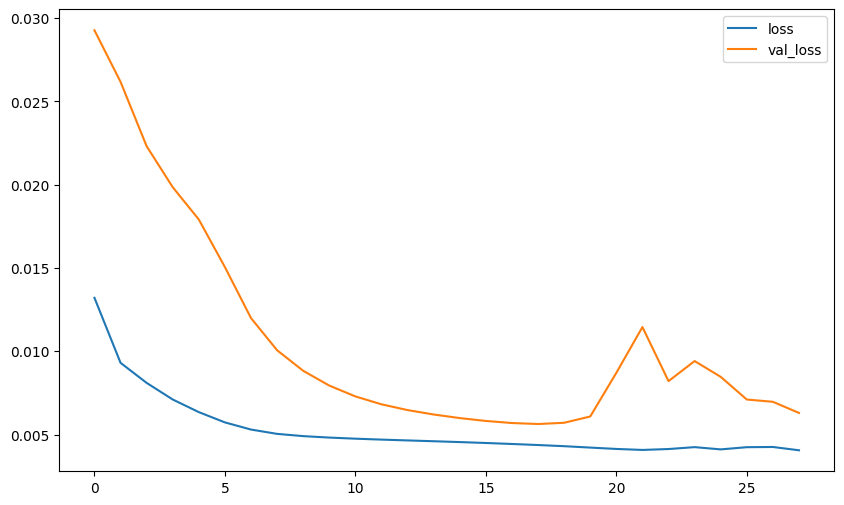

35/35 [==============================] - 1s 12ms/step


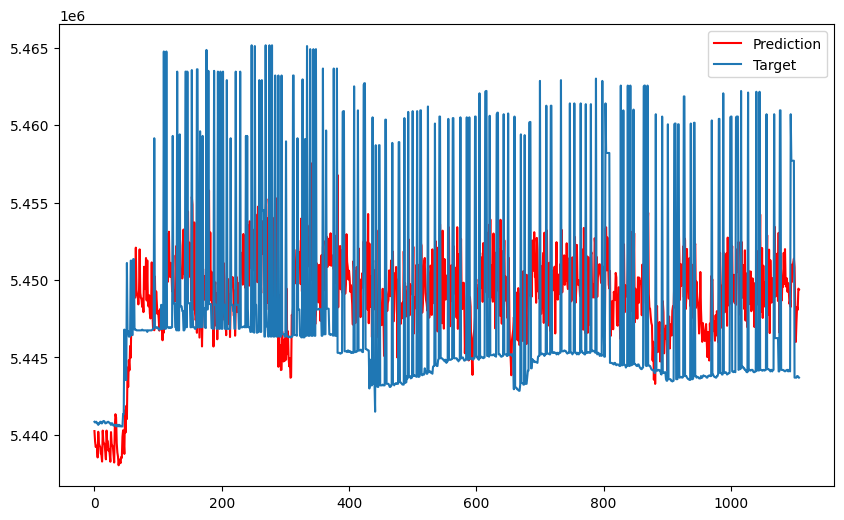

RMSE LSTM: 6111.198211230053
Random Forest with 40 features Regressor Model 1
RMSE Random Forest: 7370.568034085792
XGBoost with 40 features Regressor Model 1


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 7092.782294456897
Empty DataFrame
Columns: [Online iteration, LSTM AE 60 features, LSTM AE 20 latent, MLP, Vanilla LSTM, Random Forests, XGBoost]
Index: []
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
LSTM Autoencoder with 40 features + 20 latent Regressor Model 2
Epoch 1/50
222/222 [==============================] - 21s 68ms/step - loss: 0.0299 - val_loss: 0.0141
Epoch 2/50
222/222 [==============================] - 14s 62ms/step - loss: 0.0079 - val_loss: 0.0048
Epoch 3/50
222/222 [==============================] - 13s 61ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/50
222/222 [==============================] - 15s 69ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/50
222/222 [==============================] - 13s 60ms/step - loss: 0.0015 - val_loss: 8.0682e-04
Epoch 6

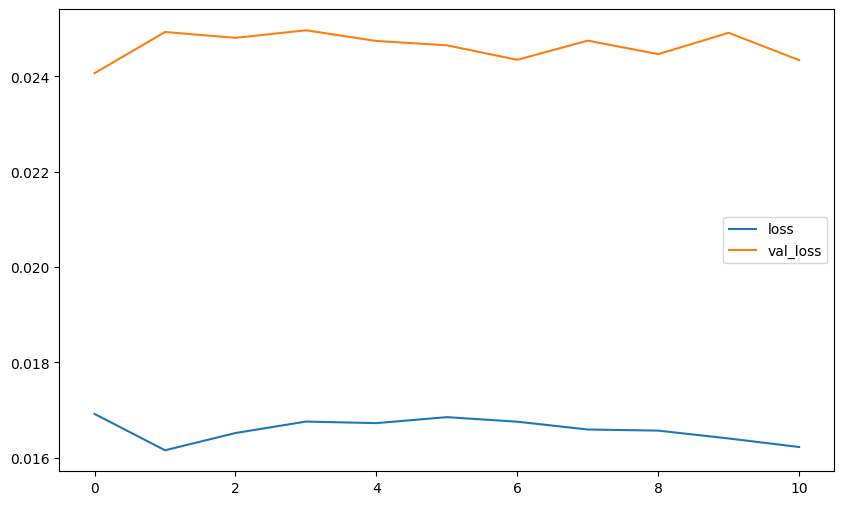

35/35 [==============================] - 1s 12ms/step


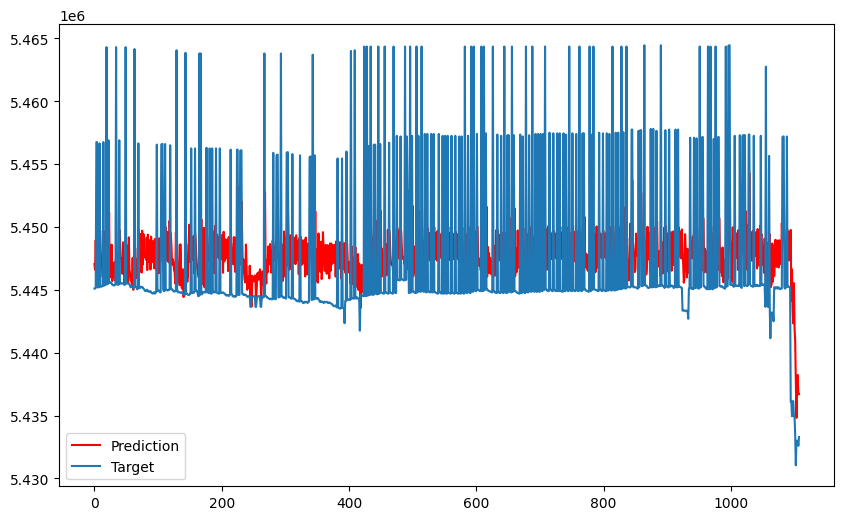

RMSE LSTM: 5466.380136374633
Random Forest with 40 features Regressor Model 2
RMSE Random Forest: 6922.04690063283
XGBoost with 40 features Regressor Model 2
RMSE XGBoost: 5733.49782853154
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   
1                2          6796.652324        6725.706775  6464.807039   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
1   5466.380136     6922.046901  5733.497829  


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


LSTM Autoencoder with 40 features + 20 latent Regressor Model 3
Epoch 1/50
222/222 [==============================] - 20s 71ms/step - loss: 0.0352 - val_loss: 0.0280
Epoch 2/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0116 - val_loss: 0.0132
Epoch 3/50
222/222 [==============================] - 15s 65ms/step - loss: 0.0043 - val_loss: 0.0083
Epoch 4/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 5/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 6/50
222/222 [==============================] - 15s 66ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 7/50
222/222 [==============================] - 15s 66ms/step - loss: 8.7466e-04 - val_loss: 0.0037
Epoch 8/50
222/222 [==============================] - 15s 66ms/step - loss: 6.9645e-04 - val_loss: 0.0034
Epoch 9/50
222/222 [==============================] - 15s 66ms/step - loss: 5.7018e-04 - val_loss: 0.0031
Epoch 

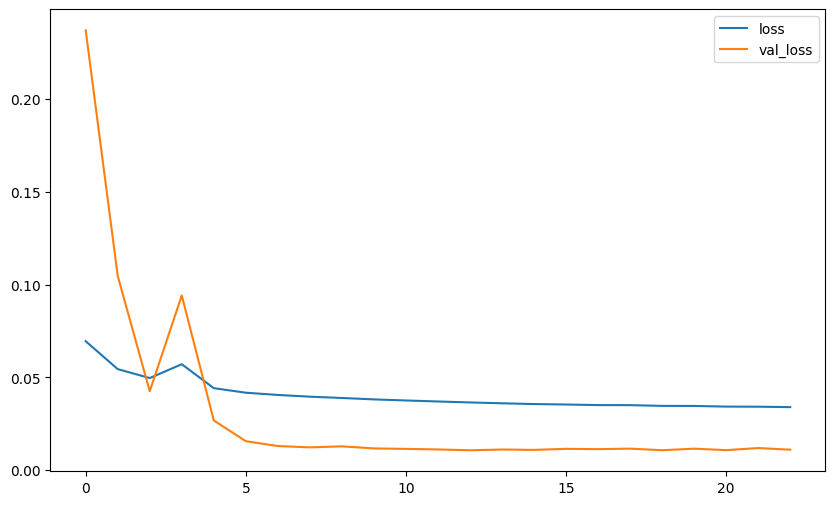

35/35 [==============================] - 1s 12ms/step


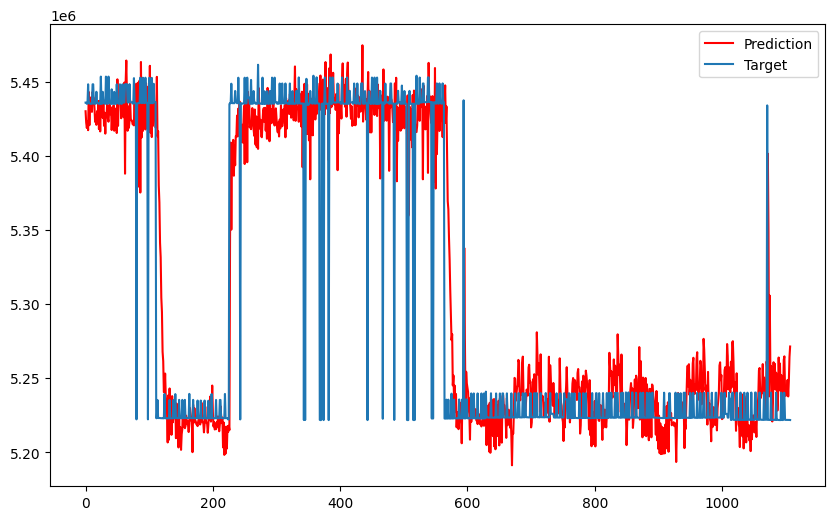

RMSE LSTM: 40798.79827132751
Random Forest with 40 features Regressor Model 3
RMSE Random Forest: 89262.53275618645
XGBoost with 40 features Regressor Model 3


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 88679.67587764817
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent          MLP  \
0                1          6801.212989        6669.309465  6405.397087   
1                2          6796.652324        6725.706775  6464.807039   

   Vanilla LSTM  Random Forests      XGBoost  
0   6111.198211     7370.568034  7092.782294  
1   5466.380136     6922.046901  5733.497829  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
LSTM Autoencoder with 40 features + 20 latent Regressor Model 4
Epoch 1/50
222/222 [====================

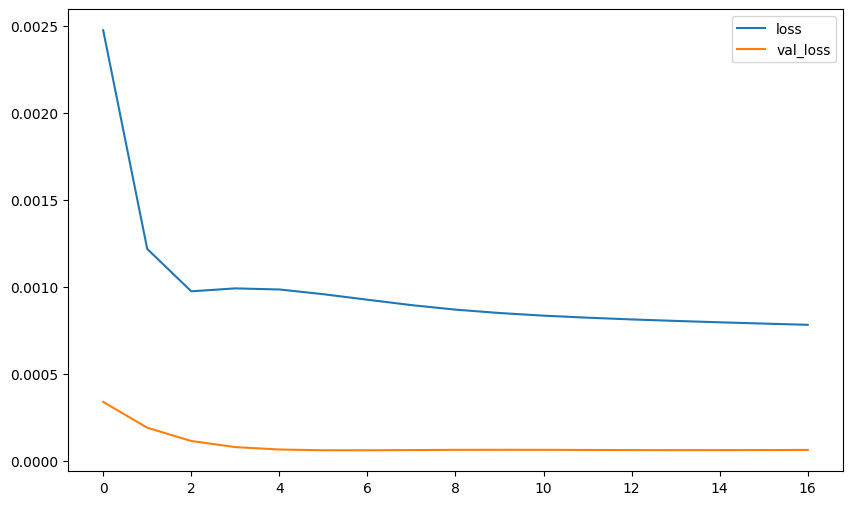

35/35 [==============================] - 1s 12ms/step


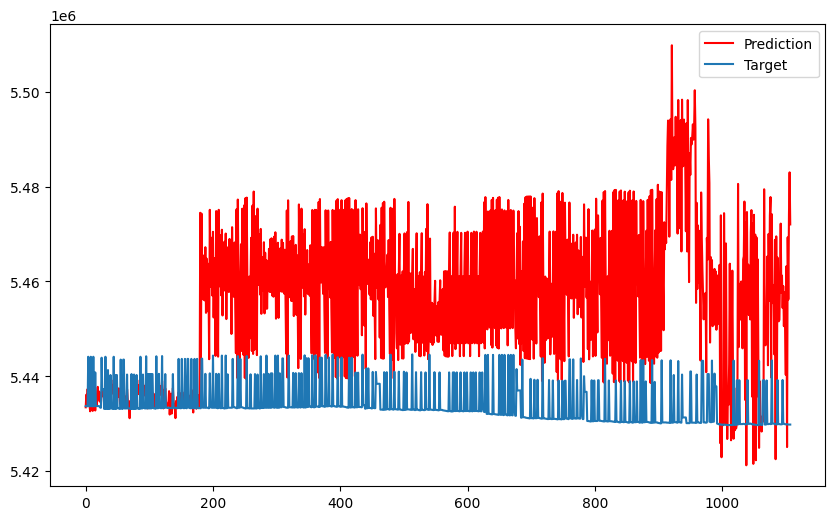

RMSE LSTM: 27032.985654241853
Random Forest with 40 features Regressor Model 4
RMSE Random Forest: 31297.25676396675
XGBoost with 40 features Regressor Model 4


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 4920.329301937923
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782

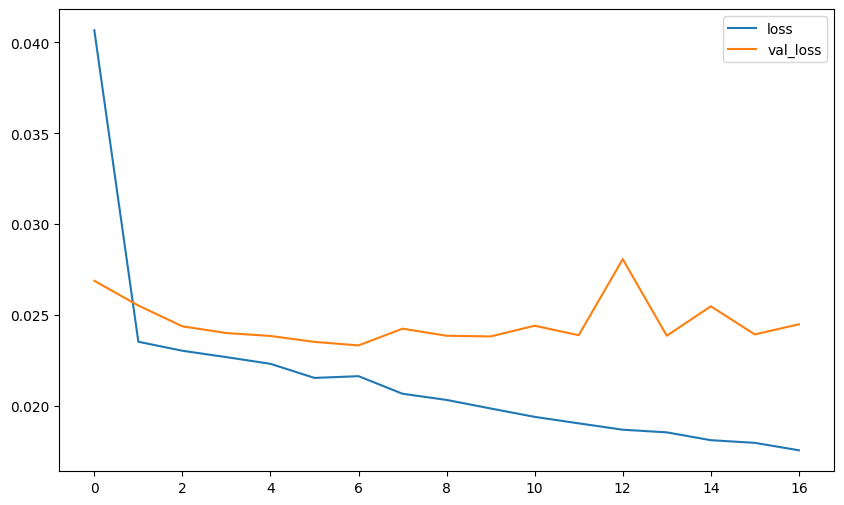

35/35 [==============================] - 1s 15ms/step


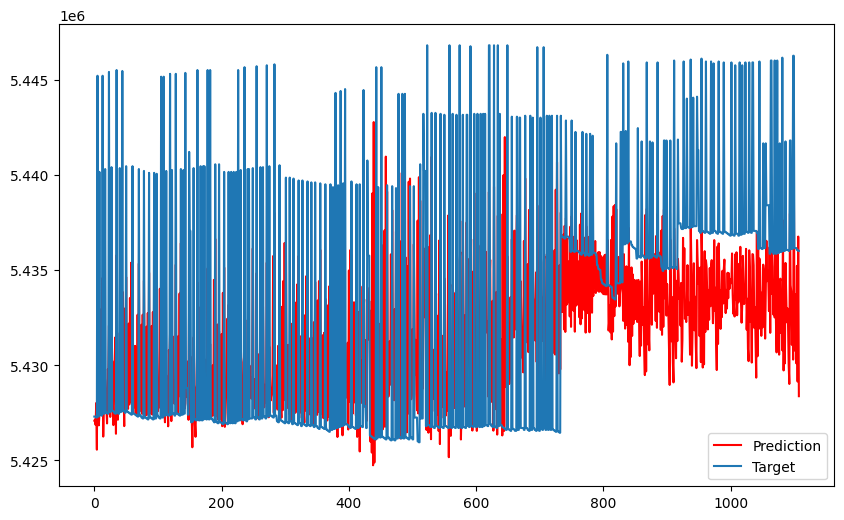

RMSE LSTM: 5271.140210514984
Random Forest with 40 features Regressor Model 5
RMSE Random Forest: 6399.077296048957
XGBoost with 40 features Regressor Model 5


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 6182.607952959657
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664    

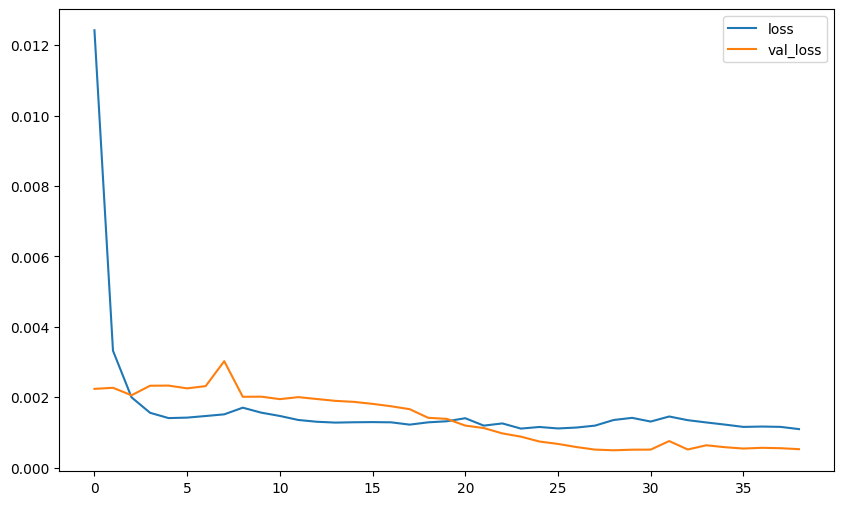

35/35 [==============================] - 1s 12ms/step


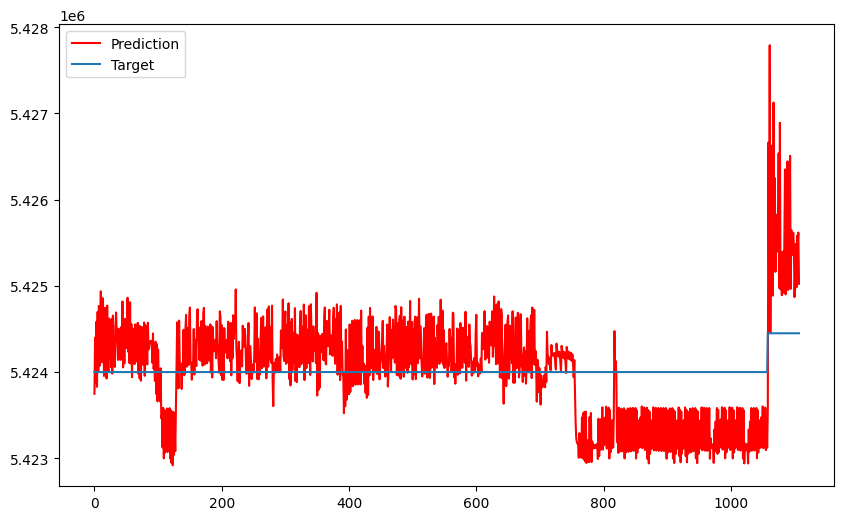

RMSE LSTM: 583.5261255245348
Random Forest with 40 features Regressor Model 6
RMSE Random Forest: 318.94621397364284
XGBoost with 40 features Regressor Model 6


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 275.3053548205286
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607953  
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.80703

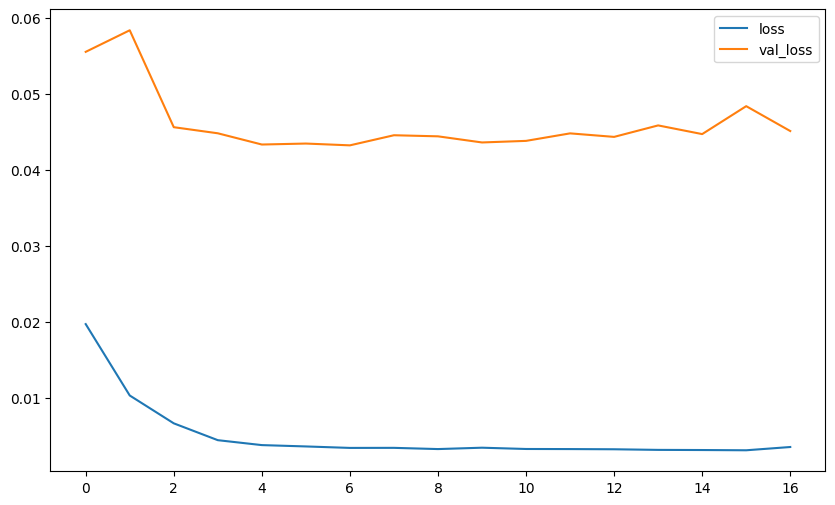

35/35 [==============================] - 1s 12ms/step


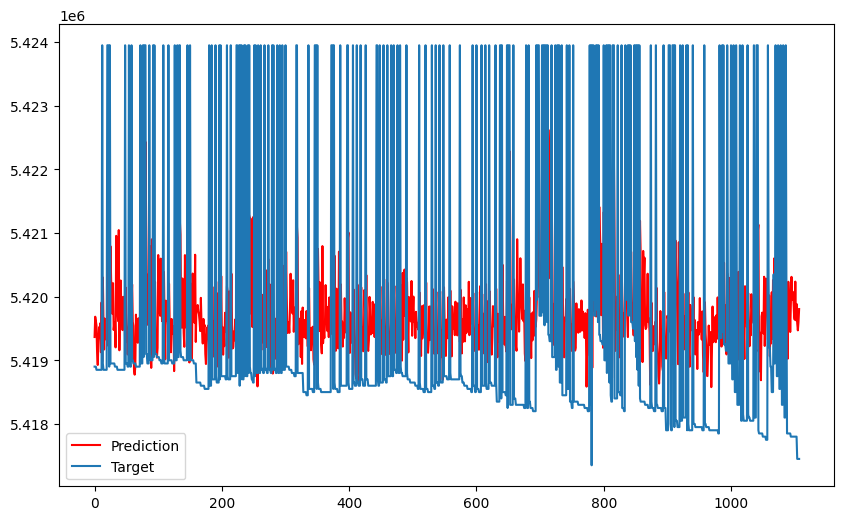

RMSE LSTM: 2000.3214673392297
Random Forest with 40 features Regressor Model 7
RMSE Random Forest: 4629.383784466577
XGBoost with 40 features Regressor Model 7
RMSE XGBoost: 2656.5905140143277
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


LSTM Autoencoder with 40 features + 20 latent Regressor Model 8
Epoch 1/50
222/222 [==============================] - 21s 71ms/step - loss: 0.0495 - val_loss: 0.0312
Epoch 2/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0174 - val_loss: 0.0107
Epoch 3/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 5/50
222/222 [==============================] - 15s 67ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/50
222/222 [==============================] - 16s 70ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/50
222/222 [==============================] - 15s 68ms/step - loss: 8.2130e-04 - val_loss: 9.8656e-04
Epoch 8/50
222/222 [==============================] - 15s 67ms/step - loss: 6.7418e-04 - val_loss: 8.9378e-04
Epoch 9/50
222/222 [==============================] - 15s 67ms/step - loss: 5.5841e-04 - val_loss: 7.146

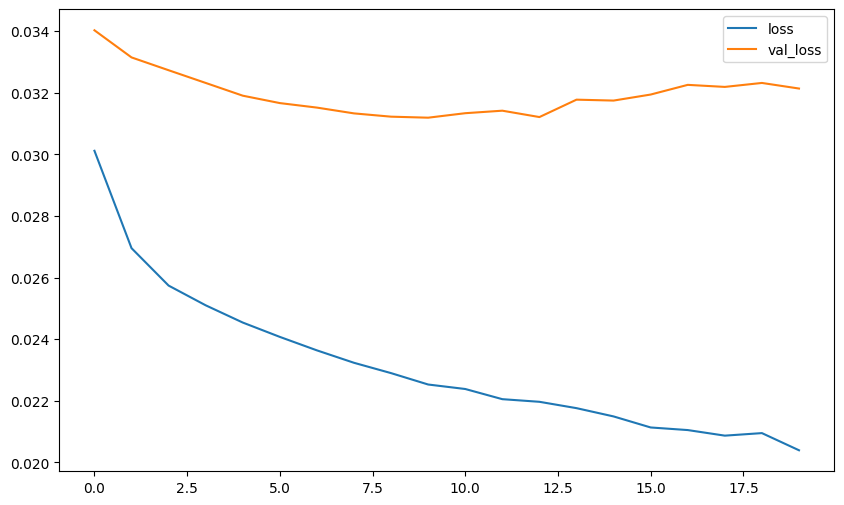

35/35 [==============================] - 1s 13ms/step


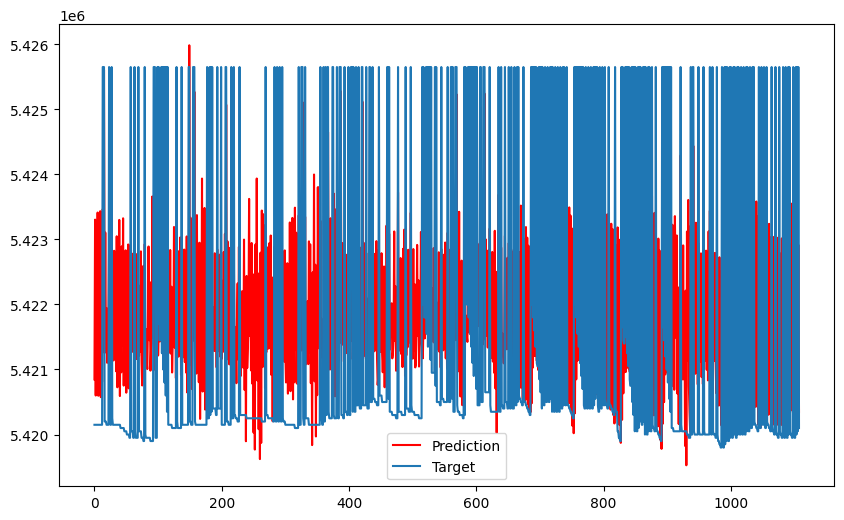

RMSE LSTM: 1983.6692343530947
Random Forest with 40 features Regressor Model 8
RMSE Random Forest: 2452.3877883573587
XGBoost with 40 features Regressor Model 8


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 2612.0196150952906
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607953  
5    583.526126      318.946214    275.305355  
6   2000.321467     46

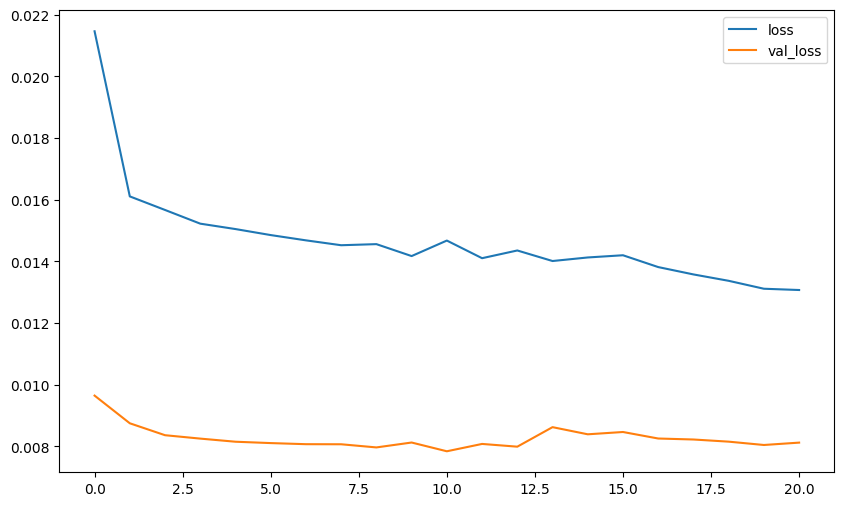

35/35 [==============================] - 1s 13ms/step


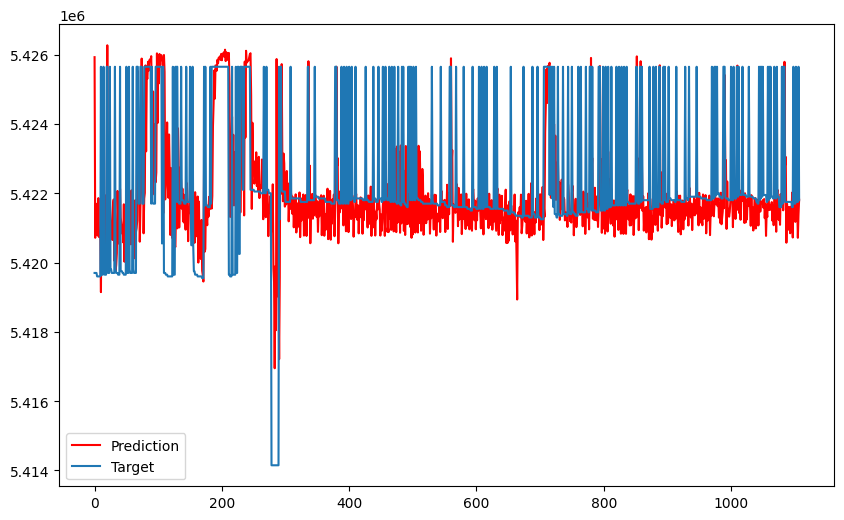

RMSE LSTM: 1828.3629248889026
Random Forest with 40 features Regressor Model 9
RMSE Random Forest: 1997.751037795631
XGBoost with 40 features Regressor Model 9


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 2065.6005763630656
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   
7                8          2116.571344        2019.415155   2135.162202   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607

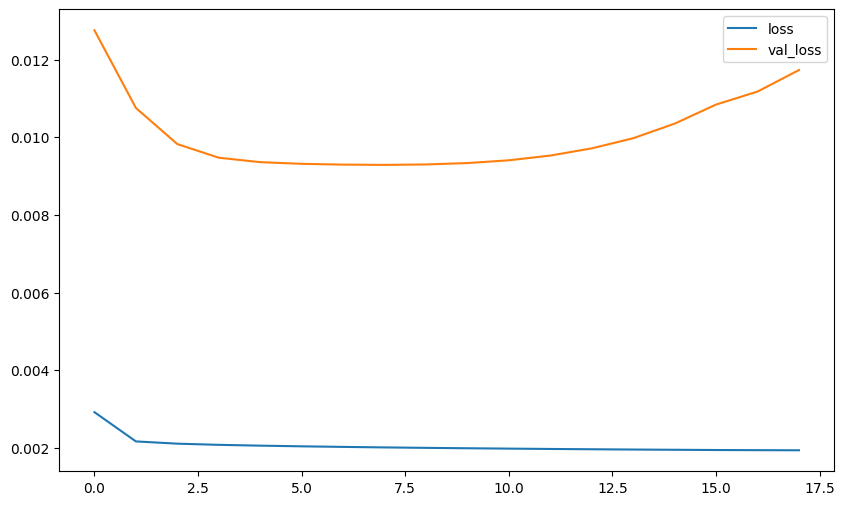

35/35 [==============================] - 1s 18ms/step


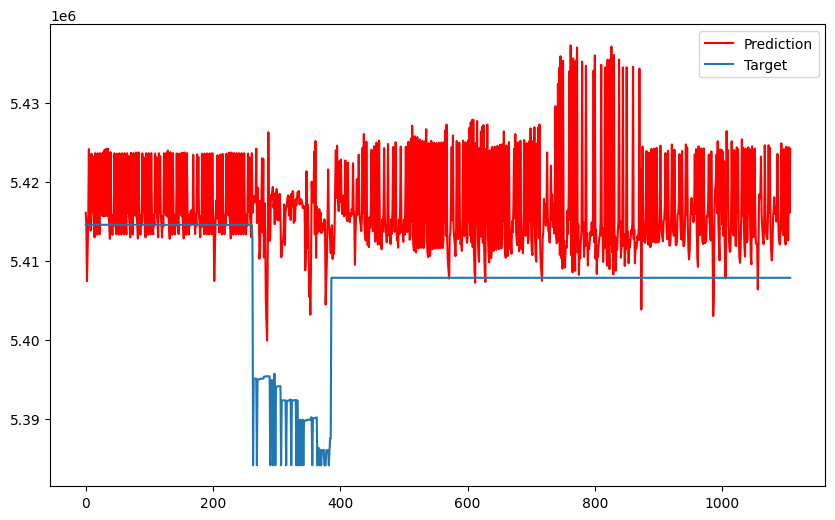

RMSE LSTM: 12153.312779950276
Random Forest with 40 features Regressor Model 10
RMSE Random Forest: 13174.06131871578
XGBoost with 40 features Regressor Model 10


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RMSE XGBoost: 9475.655667334799
  Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   
7                8          2116.571344        2019.415155   2135.162202   
8                9          1973.031398        1926.461759   2000.930815   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654

In [32]:
# LSTM AE 60 features + LSTM AE 40 features + MLP + Vanilla LSTM +
# RandomForestRegressor + XGBoost Online Learning

# Create empty dataframe as a table to save RMSE result
df_results = pd.DataFrame(
    columns=[
        'Online iteration',
        'LSTM AE 60 features',
        'LSTM AE 20 latent',
        'MLP',
        'Vanilla LSTM',
        'Random Forests',
        'XGBoost'])

for i, df_content in enumerate(data_splits):
    if i == data_chunk:
        break

    # Select all column, except the class label (last column)
    df_chunk = df_content.iloc[:, 0:52]
    array_chunk = df_chunk.values

    # Normalise the stock array
    array, scaler = normalise_data(array_chunk)

    # Preparing the data for non-LSTM models (Random Forests, XGBoost, MLP)
    # Only use original 40 features for this online learning
    features = array[:, :40]
    label = array[:, -1]
    X, X_test, y, y_test = train_test_split(
        features, label, test_size=0.20, random_state=0, shuffle=False)
    X_train, X_validate, y_train, y_validate = train_test_split(
        X, y, test_size=0.20, random_state=0, shuffle=False)

    # Preparing the data for LSTM models (LSTM, LSTM AE)
    look_back = 60  # We use 60 days as the historical data in LSTM
    horizon = 1
    features_array = np.concatenate((features, label.reshape(-1, 1)), axis=1)
    features_lstm, label_lstm = process_lstm_data(
        features_array, look_back, horizon, jump=1)
    X_lstm, X_test_lstm, y_lstm, y_test_lstm = train_test_split(
        features_lstm, label_lstm, test_size=0.20, random_state=0, shuffle=False)
    X_train_lstm, X_validate_lstm, y_train_lstm, y_validate_lstm = train_test_split(
        X_lstm, y_lstm, test_size=0.20, random_state=0, shuffle=False)

    print(
        f"LSTM Autoencoder with 40 features + 20 latent Regressor Model {i+1}")
    rmse_model1 = lstm_autoencoder_plusfeature(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i,
        20)
    print(f"LSTM Autoencoder with 20 latent Regressor Model {i+1}")
    rmse_model2 = lstm_autoencoder(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i,
        20)
    print(f"MLP with 40 features Regressor Model {i+1}")
    rmse_model3 = mlp_regression(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        i)
    print(f"Vanilla LSTM with 40 features Regressor Model {i+1}")
    rmse_model4 = lstm(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i)
    print(f"Random Forest with 40 features Regressor Model {i+1}")
    rmse_model5 = random_forest_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        100,
        5,
        2,
        1,
        i)
    print(f"XGBoost with 40 features Regressor Model {i+1}")
    rmse_model6 = xgboost_regressor(
        X_train,
        y_train,
        X_validate,
        y_validate,
        X_test,
        y_test,
        i)
    print(df_results)
    df_results = pd.concat([df_results,
                            pd.DataFrame({'Online iteration': [i + 1],
                                          'LSTM AE 60 features': [rmse_model1],
                                          'LSTM AE 20 latent': [rmse_model2],
                                          'MLP': [rmse_model3],
                                          'Vanilla LSTM': [rmse_model4],
                                          'Random Forests': [rmse_model5],
                                          'XGBoost': [rmse_model6]})],
                           ignore_index=True)
    print(df_results)



In [ ]:
# Save the RMSE result to CVS in Google Drive
df_results.to_csv('/drive/My Drive/Colab Notebooks/FML 2/results.csv', index=True)

In [66]:
# Online learning results
df_results
# From the result, vanilla LSTM is chosen as the suitable algorithm

# Random Forests and XGBoost are rejected as the model
# due to the lack of ability to capture temporal dependency

# 20 latent dimension features extracted from AE do not
# improve the vanilla LSTM

Online iteration  LSTM AE 60 features  LSTM AE 20 latent           MLP  \
0                1          6801.212989        6669.309465   6405.397087   
1                2          6796.652324        6725.706775   6464.807039   
2                3         75220.253758       80807.928896  85305.364425   
3                4         31062.864664        6362.484980  36112.701567   
4                5          6116.524720        5307.332408   6359.069232   
5                6          1453.591891        1708.294980   1389.734720   
6                7          4490.239894        5149.406566   2445.770109   
7                8          2116.571344        2019.415155   2135.162202   
8                9          1973.031398        1926.461759   2000.930815   
9               10          8469.755017       12184.122087   6396.830073   

   Vanilla LSTM  Random Forests       XGBoost  
0   6111.198211     7370.568034   7092.782294  
1   5466.380136     6922.046901   5733.497829  
2  40798.798271    89262.532756  88679.675878  
3  27032.985654    31297.256764   4920.329302  
4   5271.140211     6399.077296   6182.607953  
5    583.526126      318.946214    275.305355  
6   2000.321467     4629.383784   2656.590514  
7   1983.669234     2452.387788   2612.019615  
8   1828.362925     1997.751038   2065.600576  
9  12153.312780    13174.061319   9475.655667

LSTM with 51 features Regressor Model 1
Epoch 1/100
222/222 [==============================] - 12s 42ms/step - loss: 0.0157 - val_loss: 0.0340
Epoch 2/100
222/222 [==============================] - 7s 32ms/step - loss: 0.0097 - val_loss: 0.0365
Epoch 3/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0095 - val_loss: 0.0214
Epoch 4/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0075 - val_loss: 0.0175
Epoch 5/100
222/222 [==============================] - 9s 38ms/step - loss: 0.0065 - val_loss: 0.0151
Epoch 6/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0058 - val_loss: 0.0131
Epoch 7/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 8/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 9/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 10/100
222/222 [===================

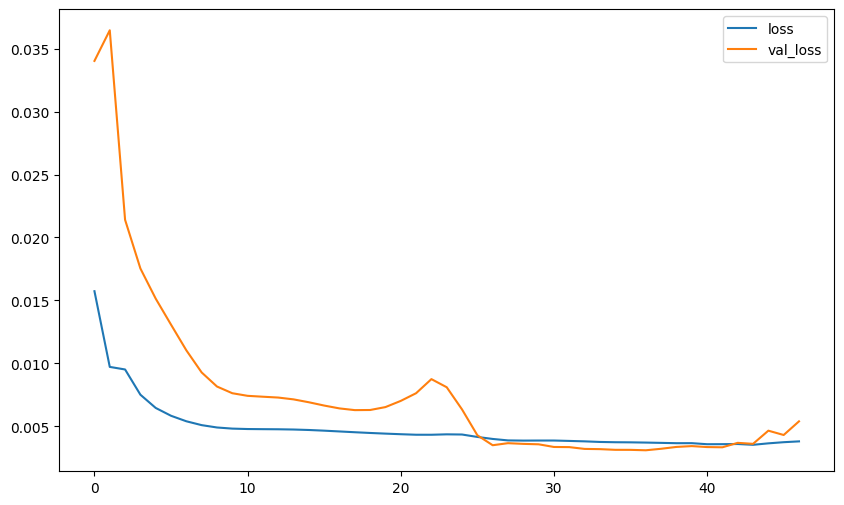

35/35 [==============================] - 1s 17ms/step


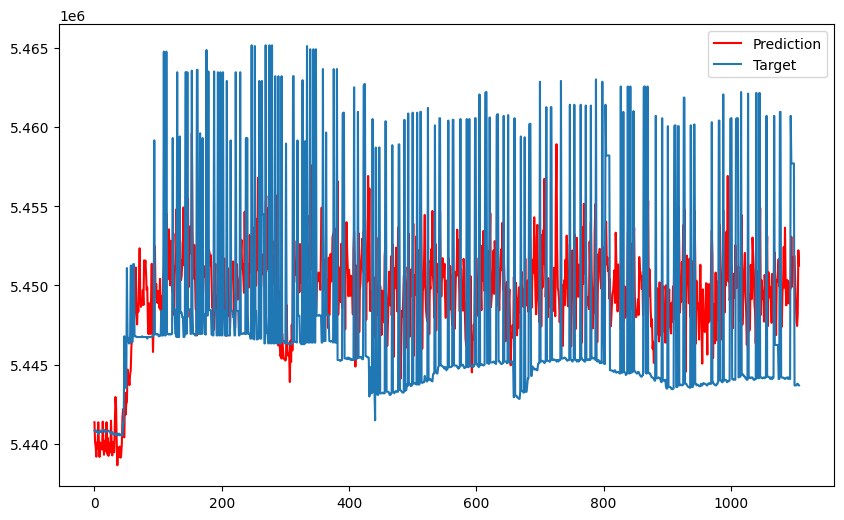

RMSE LSTM: 6289.685837670971
LSTM with 51 features Regressor Model 2
Epoch 1/100
222/222 [==============================] - 11s 40ms/step - loss: 0.0174 - val_loss: 0.0230
Epoch 2/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0161 - val_loss: 0.0240
Epoch 3/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0170 - val_loss: 0.0229
Epoch 4/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0160 - val_loss: 0.0237
Epoch 5/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0169 - val_loss: 0.0226
Epoch 6/100
222/222 [==============================] - 7s 33ms/step - loss: 0.0158 - val_loss: 0.0234
Epoch 7/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0166 - val_loss: 0.0226
Epoch 8/100
222/222 [==============================] - 9s 38ms/step - loss: 0.0156 - val_loss: 0.0233
Epoch 9/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0161 - val_loss: 0.0226
Epoch 10/10

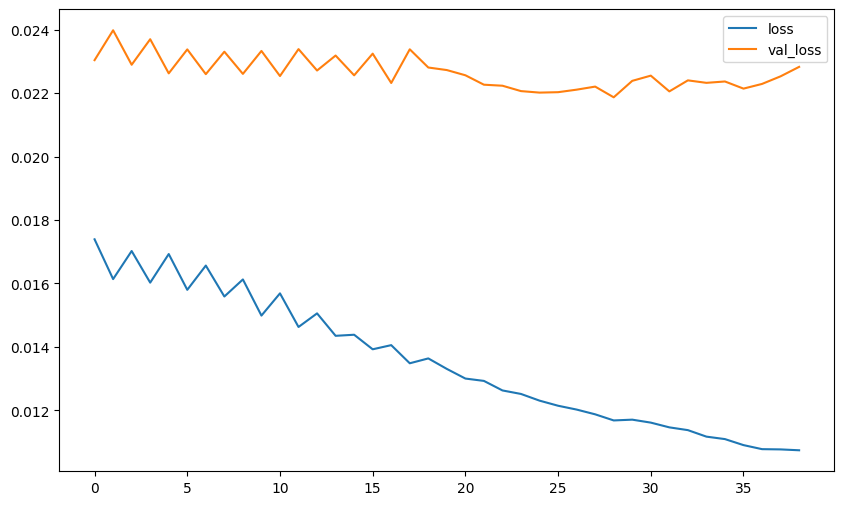

35/35 [==============================] - 1s 12ms/step


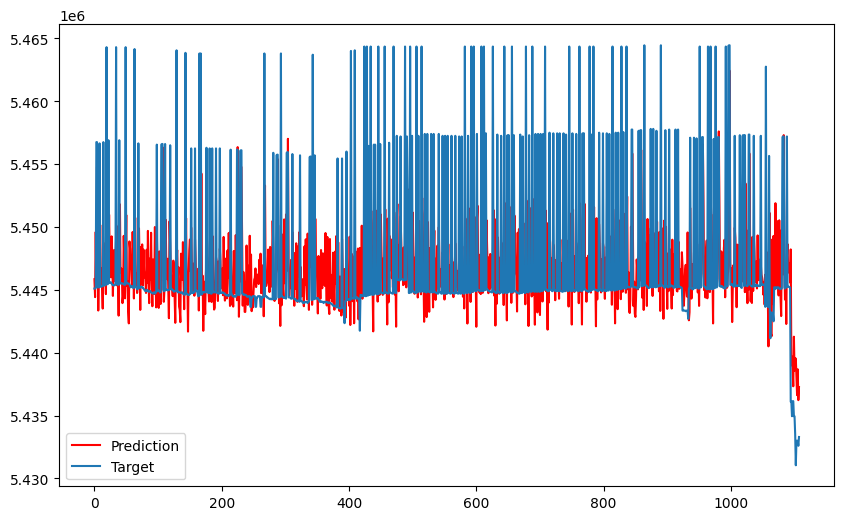

RMSE LSTM: 5412.297878747417
LSTM with 51 features Regressor Model 3
Epoch 1/100
222/222 [==============================] - 12s 44ms/step - loss: 0.0548 - val_loss: 0.0278
Epoch 2/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0559 - val_loss: 0.0318
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0396 - val_loss: 0.0256
Epoch 4/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0379 - val_loss: 0.0259
Epoch 5/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0371 - val_loss: 0.0291
Epoch 6/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0363 - val_loss: 0.0256
Epoch 7/100
222/222 [==============================] - 7s 34ms/step - loss: 0.0358 - val_loss: 0.0220
Epoch 8/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0352 - val_loss: 0.0247
Epoch 9/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0349 - val_loss: 0.0242
Epoch 10/100

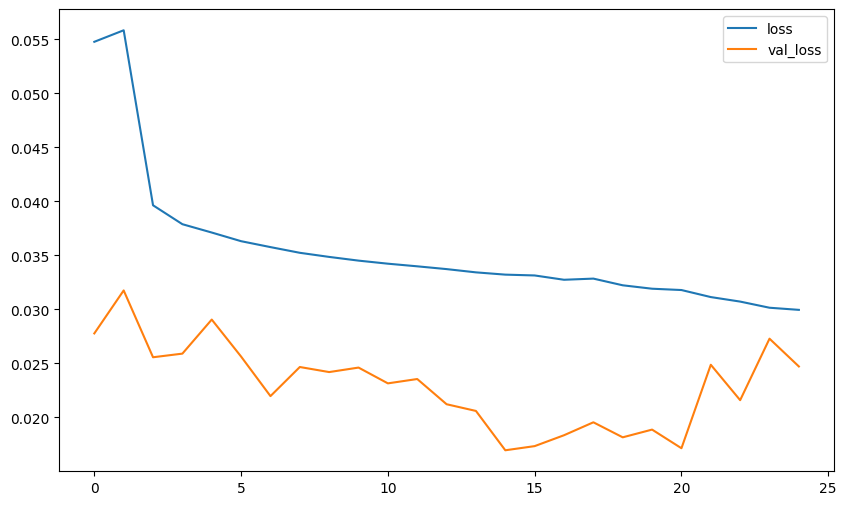

35/35 [==============================] - 1s 17ms/step


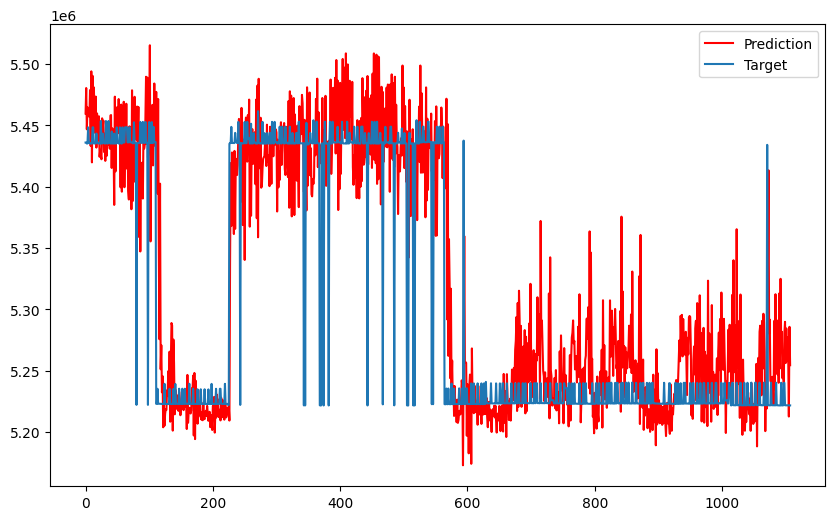

RMSE LSTM: 49965.176509054785
LSTM with 51 features Regressor Model 4
Epoch 1/100
222/222 [==============================] - 11s 37ms/step - loss: 0.0025 - val_loss: 1.9675e-04
Epoch 2/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0025 - val_loss: 1.3457e-04
Epoch 3/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0010 - val_loss: 5.9332e-05
Epoch 4/100
222/222 [==============================] - 8s 35ms/step - loss: 9.5092e-04 - val_loss: 7.6540e-05
Epoch 5/100
222/222 [==============================] - 9s 43ms/step - loss: 9.4566e-04 - val_loss: 6.3123e-05
Epoch 6/100
222/222 [==============================] - 8s 34ms/step - loss: 9.0690e-04 - val_loss: 9.8087e-05
Epoch 7/100
222/222 [==============================] - 9s 42ms/step - loss: 8.7326e-04 - val_loss: 8.8947e-05
Epoch 8/100
222/222 [==============================] - 8s 35ms/step - loss: 8.4937e-04 - val_loss: 1.3295e-04
Epoch 9/100
222/222 [==============================] - 9s 42m

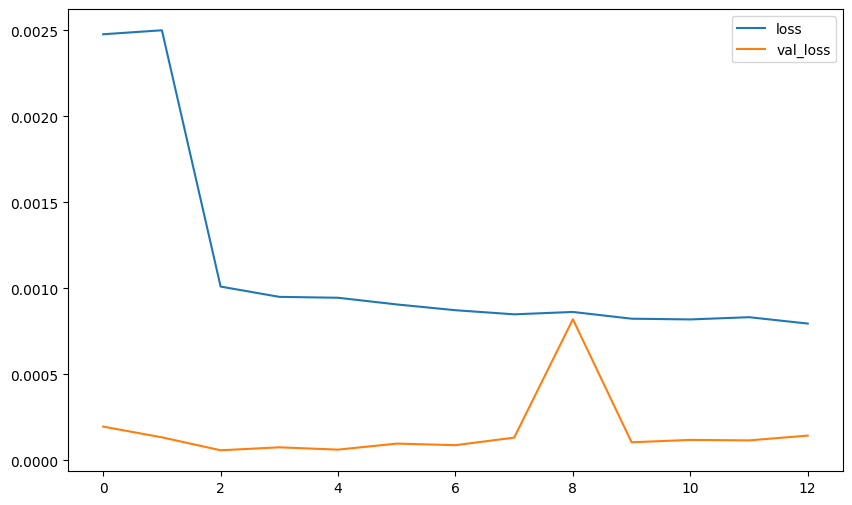

35/35 [==============================] - 1s 12ms/step


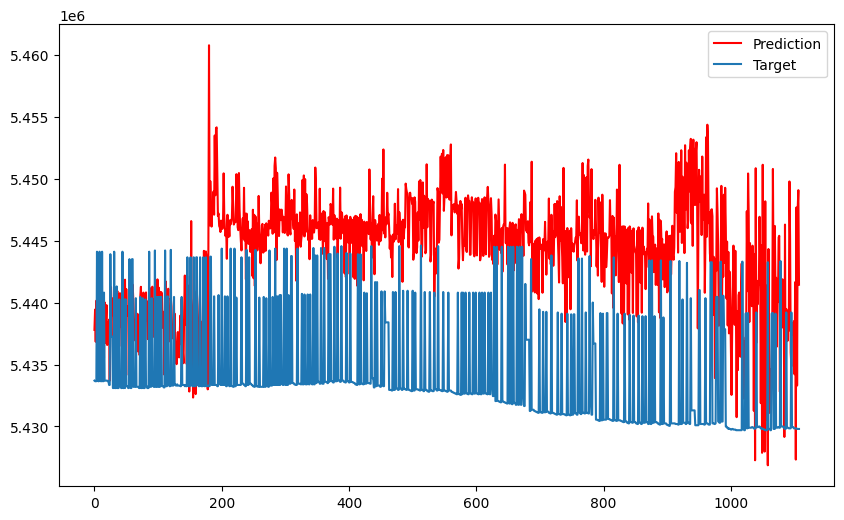

RMSE LSTM: 11721.471020232862
LSTM with 51 features Regressor Model 5
Epoch 1/100
222/222 [==============================] - 12s 45ms/step - loss: 0.0429 - val_loss: 0.0381
Epoch 2/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0268 - val_loss: 0.0310
Epoch 3/100
222/222 [==============================] - 9s 43ms/step - loss: 0.0247 - val_loss: 0.0285
Epoch 4/100
222/222 [==============================] - 8s 34ms/step - loss: 0.0230 - val_loss: 0.0259
Epoch 5/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0225 - val_loss: 0.0250
Epoch 6/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0216 - val_loss: 0.0242
Epoch 7/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0210 - val_loss: 0.0235
Epoch 8/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0205 - val_loss: 0.0235
Epoch 9/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0200 - val_loss: 0.0236
Epoch 10/10

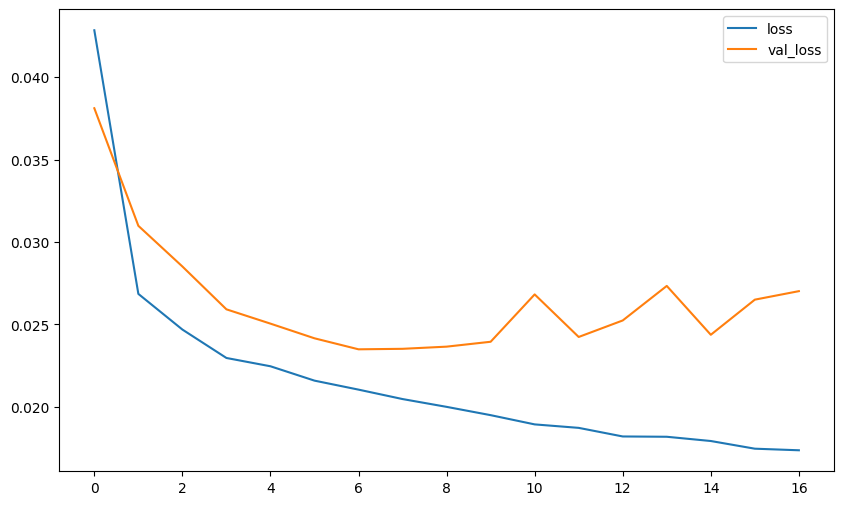

35/35 [==============================] - 1s 13ms/step


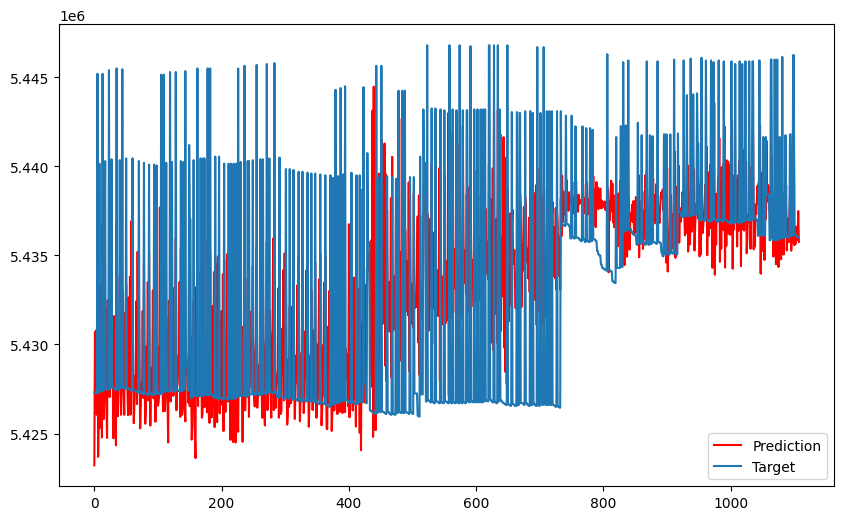

RMSE LSTM: 5391.0292030795645
LSTM with 51 features Regressor Model 6
Epoch 1/100
222/222 [==============================] - 12s 46ms/step - loss: 0.0067 - val_loss: 9.3009e-04
Epoch 2/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0038 - val_loss: 7.7813e-04
Epoch 3/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0014 - val_loss: 7.0325e-04
Epoch 4/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0013 - val_loss: 6.2958e-04
Epoch 5/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0013 - val_loss: 6.5049e-04
Epoch 6/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0014 - val_loss: 6.2528e-04
Epoch 7/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0014 - val_loss: 6.6872e-04
Epoch 8/100
222/222 [==============================] - 10s 46ms/step - loss: 0.0014 - val_loss: 6.3934e-04
Epoch 9/100
222/222 [==============================] - 8s 36ms/step - loss: 0.

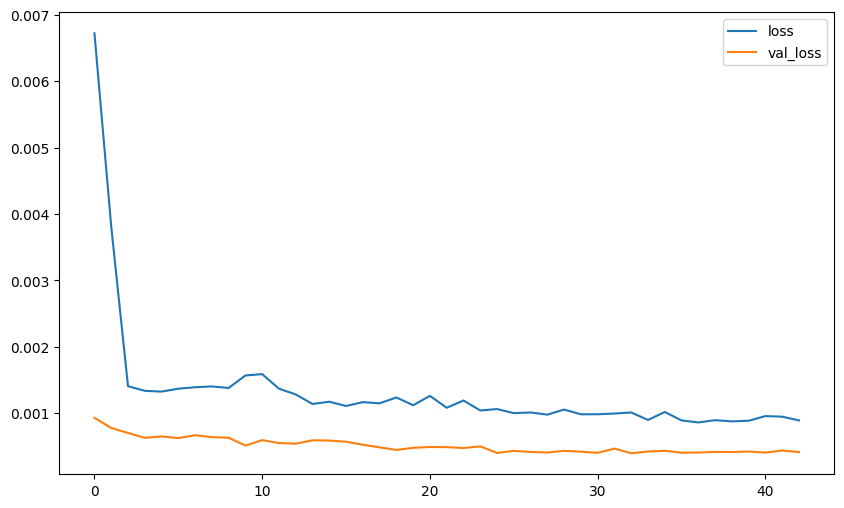

35/35 [==============================] - 1s 13ms/step


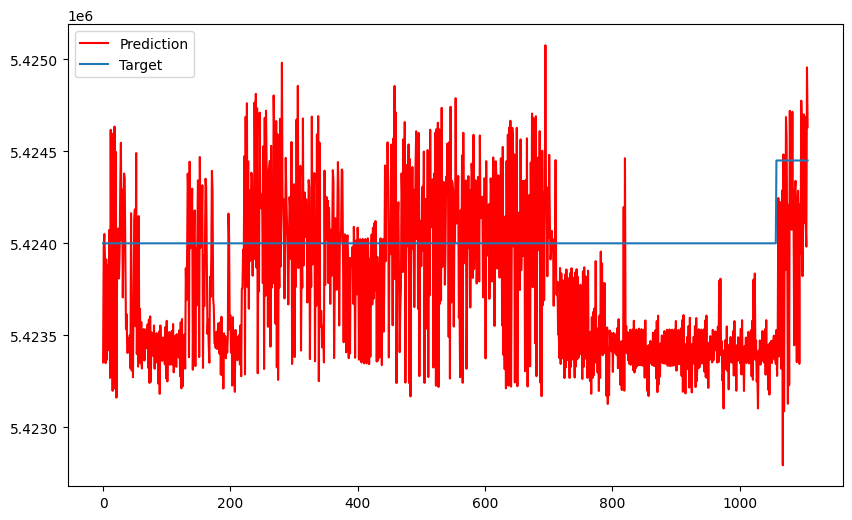

RMSE LSTM: 499.229011397875
LSTM with 51 features Regressor Model 7
Epoch 1/100
222/222 [==============================] - 11s 37ms/step - loss: 0.0123 - val_loss: 0.0566
Epoch 2/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0059 - val_loss: 0.0545
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0041 - val_loss: 0.0502
Epoch 4/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0035 - val_loss: 0.0496
Epoch 5/100
222/222 [==============================] - 9s 40ms/step - loss: 0.0032 - val_loss: 0.0490
Epoch 6/100
222/222 [==============================] - 9s 38ms/step - loss: 0.0030 - val_loss: 0.0499
Epoch 7/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0029 - val_loss: 0.0514
Epoch 8/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0027 - val_loss: 0.0515
Epoch 9/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0025 - val_loss: 0.0514
Epoch 10/1

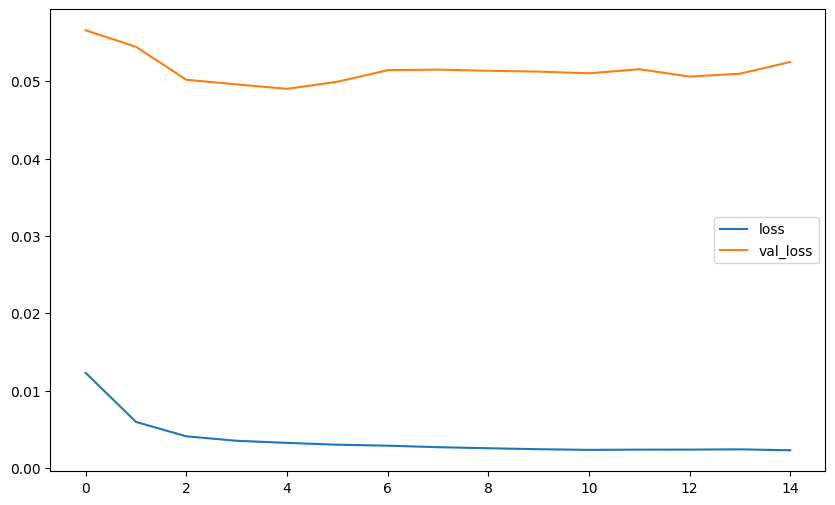

35/35 [==============================] - 1s 13ms/step


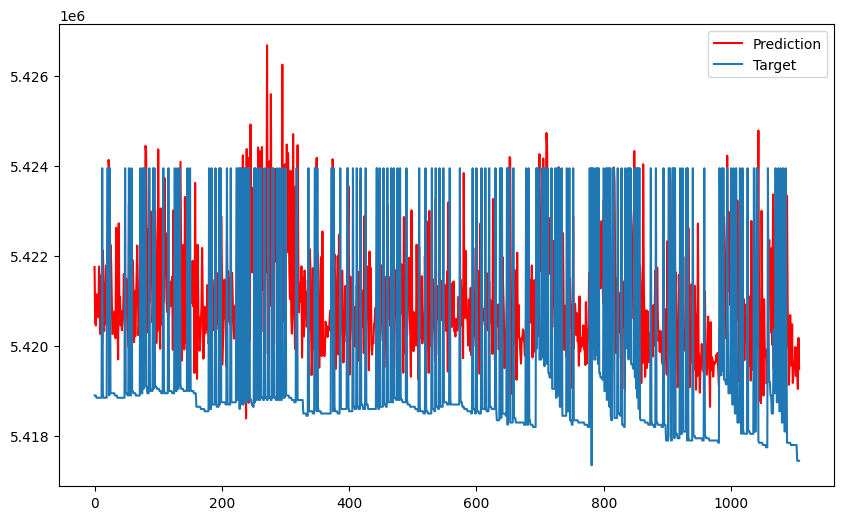

RMSE LSTM: 2607.2141336698573
LSTM with 51 features Regressor Model 8
Epoch 1/100
222/222 [==============================] - 13s 46ms/step - loss: 0.0356 - val_loss: 0.0330
Epoch 2/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0276 - val_loss: 0.0328
Epoch 3/100
222/222 [==============================] - 9s 42ms/step - loss: 0.0257 - val_loss: 0.0323
Epoch 4/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0246 - val_loss: 0.0317
Epoch 5/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0238 - val_loss: 0.0313
Epoch 6/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0232 - val_loss: 0.0311
Epoch 7/100
222/222 [==============================] - 8s 35ms/step - loss: 0.0227 - val_loss: 0.0313
Epoch 8/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0224 - val_loss: 0.0312
Epoch 9/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0222 - val_loss: 0.0318
Epoch 10

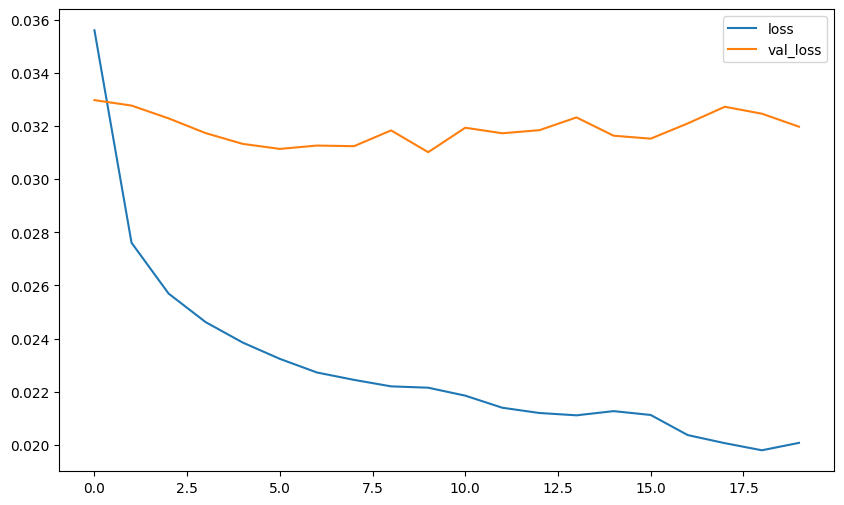

35/35 [==============================] - 1s 13ms/step


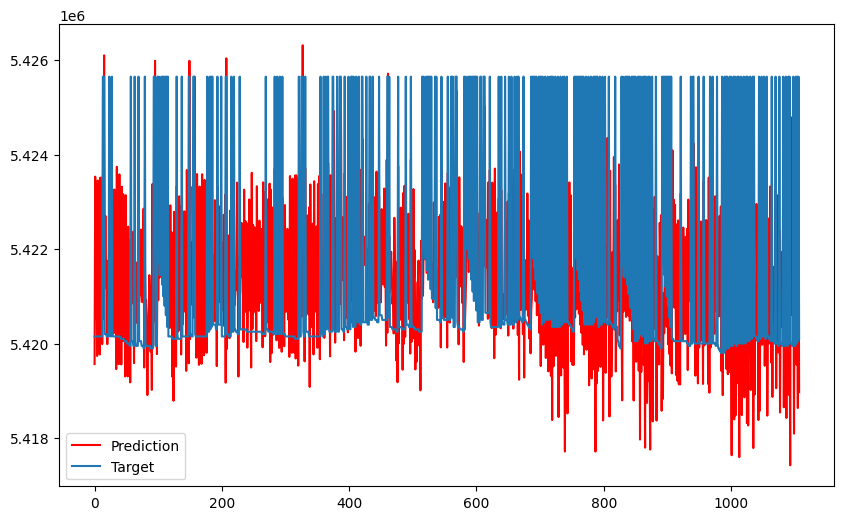

RMSE LSTM: 2067.0231388616
LSTM with 51 features Regressor Model 9
Epoch 1/100
222/222 [==============================] - 13s 46ms/step - loss: 0.0178 - val_loss: 0.0097
Epoch 2/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0154 - val_loss: 0.0081
Epoch 3/100
222/222 [==============================] - 10s 45ms/step - loss: 0.0146 - val_loss: 0.0078
Epoch 4/100
222/222 [==============================] - 8s 37ms/step - loss: 0.0143 - val_loss: 0.0077
Epoch 5/100
222/222 [==============================] - 9s 43ms/step - loss: 0.0142 - val_loss: 0.0077
Epoch 6/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 7/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0139 - val_loss: 0.0080
Epoch 8/100
222/222 [==============================] - 10s 44ms/step - loss: 0.0139 - val_loss: 0.0081
Epoch 9/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0138 - val_loss: 0.0083
Epoch 10/100

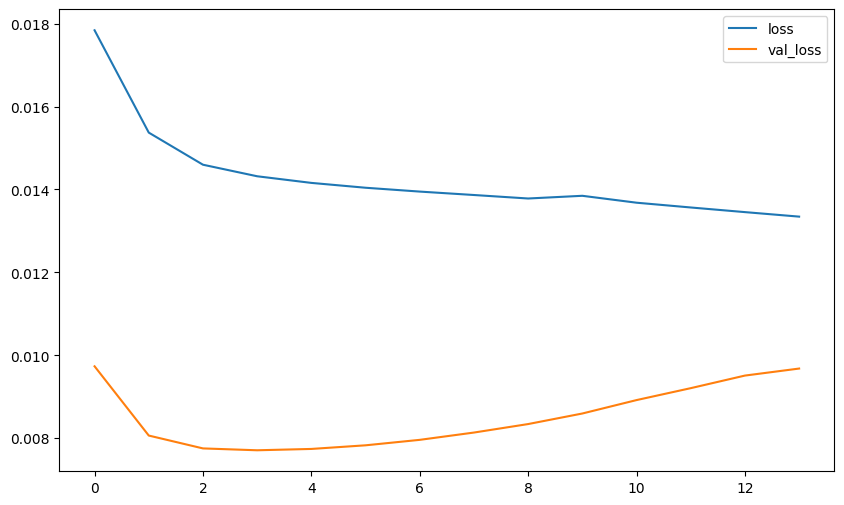

35/35 [==============================] - 1s 13ms/step


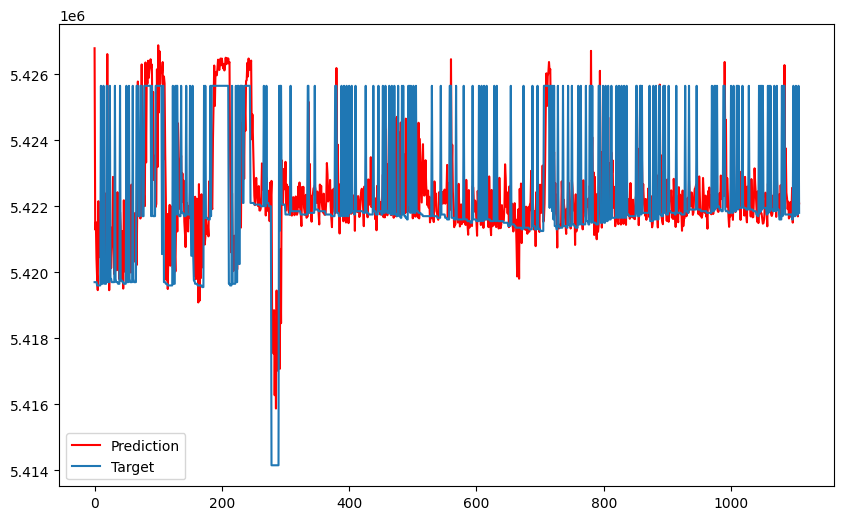

RMSE LSTM: 1687.0476113763184
LSTM with 51 features Regressor Model 10
Epoch 1/100
222/222 [==============================] - 12s 41ms/step - loss: 0.0026 - val_loss: 0.0371
Epoch 2/100
222/222 [==============================] - 10s 45ms/step - loss: 0.0021 - val_loss: 0.0385
Epoch 3/100
222/222 [==============================] - 8s 36ms/step - loss: 0.0021 - val_loss: 0.0374
Epoch 4/100
222/222 [==============================] - 10s 46ms/step - loss: 0.0020 - val_loss: 0.0360
Epoch 5/100
222/222 [==============================] - 8s 38ms/step - loss: 0.0020 - val_loss: 0.0357
Epoch 6/100
222/222 [==============================] - 10s 43ms/step - loss: 0.0020 - val_loss: 0.0348
Epoch 7/100
222/222 [==============================] - 9s 41ms/step - loss: 0.0020 - val_loss: 0.0339
Epoch 8/100
222/222 [==============================] - 9s 39ms/step - loss: 0.0020 - val_loss: 0.0332
Epoch 9/100
222/222 [==============================] - 10s 45ms/step - loss: 0.0020 - val_loss: 0.0328
Epoch 

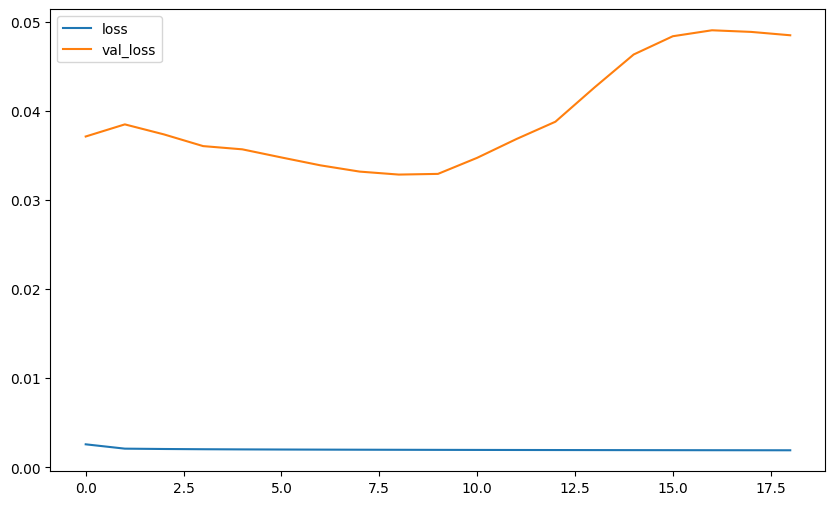

35/35 [==============================] - 1s 14ms/step


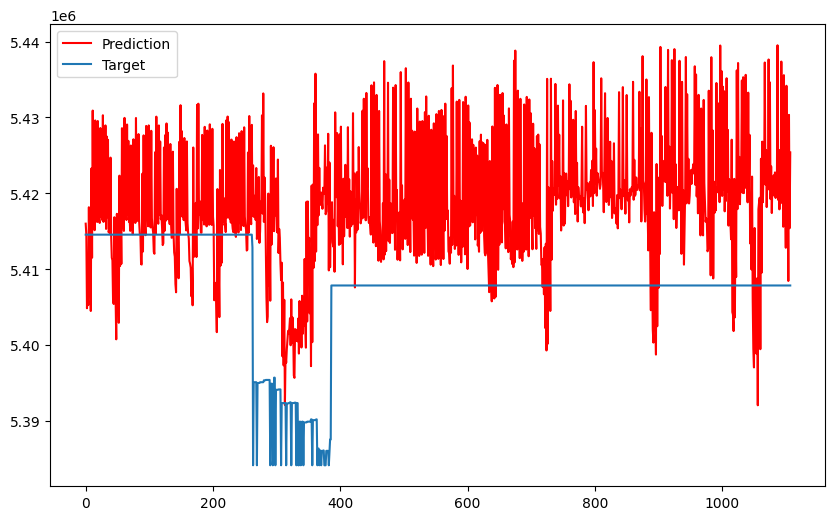

RMSE LSTM: 14648.226317151639


In [71]:
# LSTM AE 60 features + LSTM AE 40 features + MLP + Vanilla LSTM +
# RandomForestRegressor + XGBoost Online Learning

# Define on how many we want to split the data
# We simulate that 100 splits = 100 events to save resource in this assignment
num_splits = 100

# Calculate the size of each split
split_size = len(df_final) // num_splits

# Split the DataFrame into a list of smaller DataFrames
data_splits = [
    df_final.iloc[i * split_size:(i + 1) * split_size] for i in range(num_splits)]

# If there are any remaining data points, add them to the last split
if len(data_splits) % num_splits != 0:
    data_splits[-1] = data_splits[-1].append(
        df_final.iloc[num_splits * split_size:])

# How many data we want to use in this online learning simulation
# E.g. : data_chunk = 10 means 10 out of 100 chunks (10% data)
data_chunk = 10

# Create empty dataframe as a table to save RMSE result
df_results_lstm = pd.DataFrame(
    columns=[
        'Online iteration',
        'LSTM 51 features'])

for i, df_content in enumerate(data_splits):
    if i == data_chunk:
        break

    # Select all column, except the class label (last column)
    df_chunk = df_content.iloc[:, 0:52]
    array_chunk = df_chunk.values

    # Normalise the stock array
    array, scaler = normalise_data(array_chunk)

    # Preparing the data for non-LSTM models (Random Forests, XGBoost, MLP)
    # Use original 40 features+11 handcrafted features for this online learning
    features = array[:, :51]
    label = array[:, -1]
    X, X_test, y, y_test = train_test_split(
        features, label, test_size=0.20, random_state=0, shuffle=False)
    X_train, X_validate, y_train, y_validate = train_test_split(
        X, y, test_size=0.20, random_state=0, shuffle=False)

    # Preparing the data for LSTM model
    look_back = 60  # We use 60 days as the historical data in LSTM
    horizon = 1
    features_array = np.concatenate((features, label.reshape(-1, 1)), axis=1)
    features_lstm, label_lstm = process_lstm_data(
        features_array, look_back, horizon, jump=1)
    X_lstm, X_test_lstm, y_lstm, y_test_lstm = train_test_split(
        features_lstm, label_lstm, test_size=0.20, random_state=0, shuffle=False)
    X_train_lstm, X_validate_lstm, y_train_lstm, y_validate_lstm = train_test_split(
        X_lstm, y_lstm, test_size=0.20, random_state=0, shuffle=False)


    print(f"LSTM with 51 features Regressor Model {i+1}")
    rmse_model = lstm(
        X_train_lstm,
        X_validate_lstm,
        X_test_lstm,
        y_train_lstm,
        y_validate_lstm,
        y_test_lstm,
        i)

    df_results_lstm = pd.concat([df_results_lstm,
                            pd.DataFrame({'Online iteration': [i + 1],
                                          'LSTM 51 features': [rmse_model]})],
                           ignore_index=True)

# Save the RMSE result to CVS in Google Drive
df_results_lstm.to_csv(
    '/drive/My Drive/Colab Notebooks/FML 2/result_lstm_51.csv',
    index=True)


In [86]:
# Printing the result

df_results_lstm

# This result shows that 11 handcrafted features slightly improved
# the vanilla LSTM chosen from previous online learning

Online iteration  LSTM 51 features
0                1       6289.685838
1                2       5412.297879
2                3      49965.176509
3                4      11721.471020
4                5       5391.029203
5                6        499.229011
6                7       2607.214134
7                8       2067.023139
8                9       1687.047611
9               10      14648.226317